In [1]:
#!pip install --upgrade pip
!pip install fastai==0.7.0 ## Based on Fast.ai ML course

%load_ext autoreload
%autoreload 2
%matplotlib inline

     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 496.4MB 29kB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
ERROR: pytorch-pretrained-bert 0.6.2 has requirement torch>=0.4.1, but you'll have torch 0.3.1 which is incompatible.
ERROR: allennlp 0.8.4 has requirement torch>=0.4.1, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [2]:
import numpy as np 
import pandas as pd
from IPython.display import display
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import os
from pandas_summary import DataFrameSummary
from matplotlib import pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import re

import shap
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

import IPython
from IPython.display import display
print(os.listdir("../input/"))

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


['train.csv', 'sample_submission.csv', 'test.csv', 'data_description.txt']


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The evaluation criteria is RMSE of log of Sales Price. So first, let's change the target variable to log

In [4]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

We'll just use a Random Forest Regressor. For that, we need to convert all columns to numeric type. But there are some categorical variables too.

In [5]:
train_cats(train_df)
apply_cats(test_df, train_df)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable. Fastai to the rescue again !!

In [6]:
df_trn, y_trn, nas = proc_df(train_df, 'SalePrice')
df_test, _, _ = proc_df(test_df, na_dict=nas)
df_trn.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,1,60,4,65.0,8450,2,0,4,4,1,5,1,6,3,3,1,6,7,5,2003,2003,2,2,13,14,2,196.0,3,5,3,3,4,4,3,706,6,0,150,856,2,...,856,854,0,1710,1,0,2,1,3,1,3,8,7,0,0,2,2003.0,2,2,548,5,5,3,0,61,0,0,0,0,0,0,0,0,2,2008,9,5,False,False,False
1,2,20,4,80.0,9600,2,0,4,4,1,3,1,25,2,3,1,3,6,8,1976,1976,2,2,9,9,3,0.0,4,5,2,3,4,2,1,978,6,0,284,1262,2,...,1262,0,0,1262,0,1,2,0,3,1,4,6,7,1,5,2,1976.0,2,2,460,5,5,3,298,0,0,0,0,0,0,0,0,0,5,2007,9,5,False,False,False
2,3,60,4,68.0,11250,2,0,1,4,1,5,1,6,3,3,1,6,7,5,2001,2002,2,2,13,14,2,162.0,3,5,3,3,4,3,3,486,6,0,434,920,2,...,920,866,0,1786,1,0,2,1,3,1,3,6,7,1,5,2,2001.0,2,2,608,5,5,3,0,42,0,0,0,0,0,0,0,0,9,2008,9,5,False,False,False
3,4,70,4,60.0,9550,2,0,1,4,1,1,1,7,3,3,1,6,7,5,1915,1970,2,2,14,16,3,0.0,4,5,1,4,2,4,1,216,6,0,540,756,2,...,961,756,0,1717,1,0,1,0,3,1,3,7,7,1,3,6,1998.0,3,3,642,5,5,3,0,35,272,0,0,0,0,0,0,0,2,2006,9,1,False,False,False
4,5,60,4,84.0,14260,2,0,1,4,1,3,1,16,3,3,1,6,8,5,2000,2000,2,2,13,14,2,350.0,3,5,3,3,4,1,3,655,6,0,490,1145,2,...,1145,1053,0,2198,1,0,2,1,4,1,3,9,7,1,5,2,2000.0,2,3,836,5,5,3,192,84,0,0,0,0,0,0,0,0,12,2008,9,5,False,False,False


In [7]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,BsmtFinSF1_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,BsmtFullBath_na,BsmtHalfBath_na,GarageYrBlt_na,GarageCars_na,GarageArea_na
0,1461,20,3,80.0,11622,2,0,4,4,1,5,1,13,2,3,1,3,5,6,1961,1961,2,2,13,14,3,0.0,4,5,2,4,4,4,5,468.0,4,144.0,270.0,882.0,2,...,2,1,4,5,7,0,0,2,1961.0,3,1.0,730.0,5,5,3,140,0,0,0,120,0,0,3,0,0,6,2010,9,5,False,False,False,False,False,False,False,False,False,False,False
1,1462,20,4,81.0,14267,2,0,1,4,1,1,1,13,3,3,1,3,6,6,1958,1958,4,2,14,15,2,108.0,4,5,2,4,4,4,1,923.0,6,0.0,406.0,1329.0,2,...,3,1,3,6,7,0,0,2,1958.0,3,1.0,312.0,5,5,3,393,36,0,0,0,0,0,0,1,12500,6,2010,9,5,False,False,False,False,False,False,False,False,False,False,False
2,1463,60,4,74.0,13830,2,0,1,4,1,5,1,9,3,3,1,6,5,5,1997,1998,2,2,13,14,3,0.0,4,5,3,3,4,4,3,791.0,6,0.0,137.0,928.0,2,...,3,1,4,6,7,1,5,2,1997.0,1,2.0,482.0,5,5,3,212,34,0,0,0,0,0,3,0,0,3,2010,9,5,False,False,False,False,False,False,False,False,False,False,False
3,1464,60,4,78.0,9978,2,0,1,4,1,5,1,9,3,3,1,6,6,6,1998,1998,2,2,13,14,2,20.0,4,5,3,4,4,4,3,602.0,6,0.0,324.0,926.0,2,...,3,1,3,7,7,1,3,2,1998.0,1,2.0,470.0,5,5,3,360,36,0,0,0,0,0,0,0,0,6,2010,9,5,False,False,False,False,False,False,False,False,False,False,False
4,1465,120,4,43.0,5005,2,0,1,2,1,5,1,23,3,3,5,3,8,5,1992,1992,2,2,7,7,3,0.0,3,5,3,3,4,4,1,263.0,6,0.0,1017.0,1280.0,2,...,2,1,3,5,7,0,0,2,1992.0,2,2.0,506.0,5,5,3,0,82,0,0,144,0,0,0,0,0,1,2010,9,5,False,False,False,False,False,False,False,False,False,False,False


In [8]:
df_test.drop(['LotFrontage_na', 'MasVnrArea_na', 'BsmtFinSF1_na', 'BsmtFinSF2_na', 'BsmtUnfSF_na', 
              'TotalBsmtSF_na', 'BsmtFullBath_na', 'BsmtHalfBath_na', 'GarageYrBlt_na', 'GarageCars_na',
              'GarageArea_na'], axis =1, inplace = True)
df_trn.drop(['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na'], axis = 1, inplace = True)

### Defining function to calculate the evaluation metric

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(train_X), train_y), rmse(m.predict(val_X), val_y),     ## RMSE of log of prices
                m.score(train_X, train_y), m.score(val_X, val_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Split the data into training and validation sets

In [10]:
train_X, val_X, train_y, val_y = train_test_split(df_trn, y_trn, test_size=0.33, random_state=42)

We can now pass this processed data frame to Random Forest Regressor

Initially, let's just fit a single decision tree to visualize it properly

In [11]:
%time
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=3, n_jobs=-1, max_depth = 3, oob_score=True) ## Use all CPUs available
m.fit(train_X, train_y)

print_score(m)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs
[0.22238352409860165, 0.23109886477747063, 0.6788352730555882, 0.6866381985366655, -594.0357517590282]


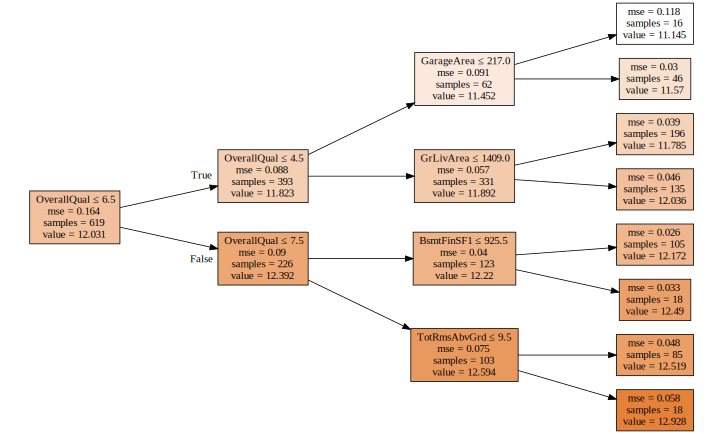

In [12]:
draw_tree(m.estimators_[0], train_X, precision=3)

A single decision tree did not perform so badly. Now, let's bag a collection of trees to create a random forest.

In [13]:
%time
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True) ## Use all CPUs available
m.fit(train_X, train_y)

print_score(m)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
[0.083041274217992, 0.14517727763672125, 0.9552172628929382, 0.8763347364078409, 0.8393624550928104]


## Permuation importance of features

In [14]:
perm = PermutationImportance(m, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.2186 ± 0.0250,OverallQual
0.0843 ± 0.0047,GrLivArea
0.0296 ± 0.0069,YearBuilt
0.0197 ± 0.0038,GarageCars
0.0169 ± 0.0027,TotalBsmtSF
0.0168 ± 0.0043,1stFlrSF
0.0135 ± 0.0032,GarageArea
0.0096 ± 0.0012,BsmtFinSF1
0.0077 ± 0.0024,LotArea
0.0071 ± 0.0027,Neighborhood


## Partial Dependence Plots

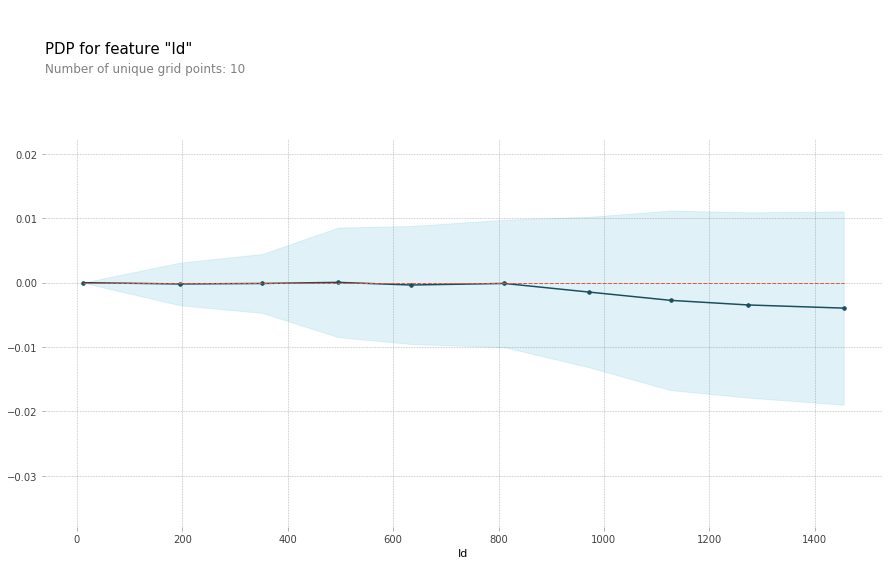

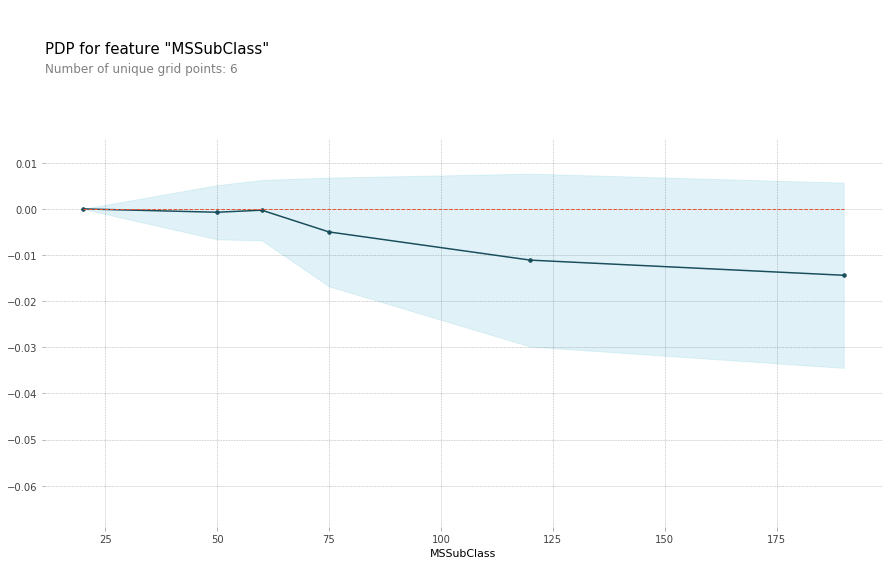

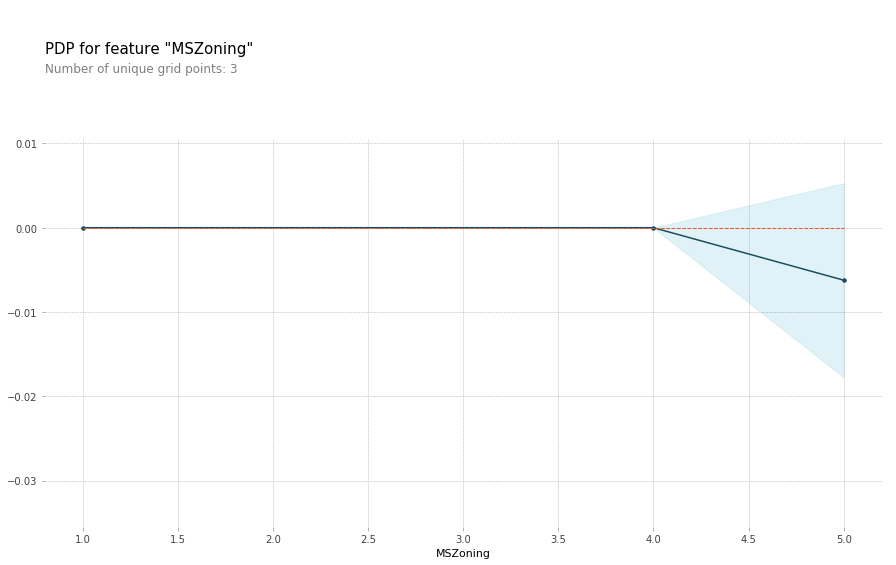

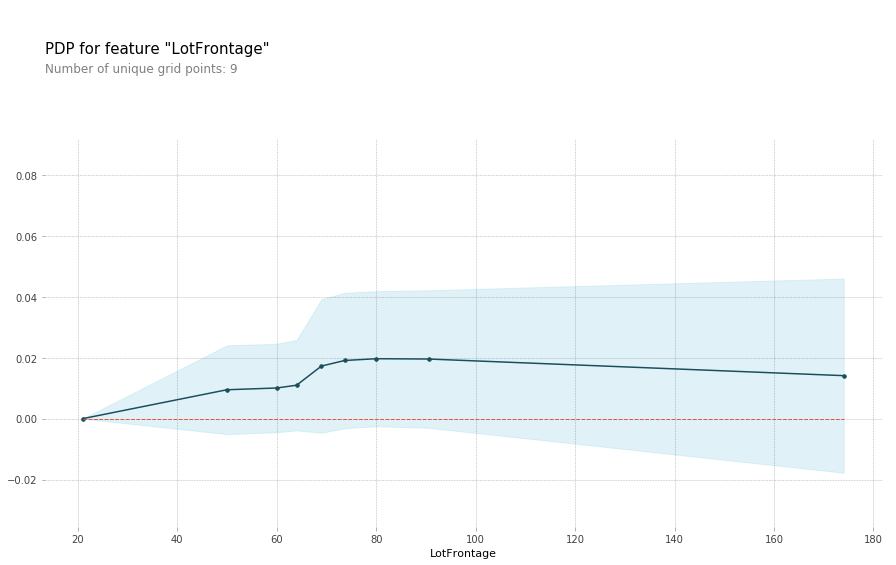

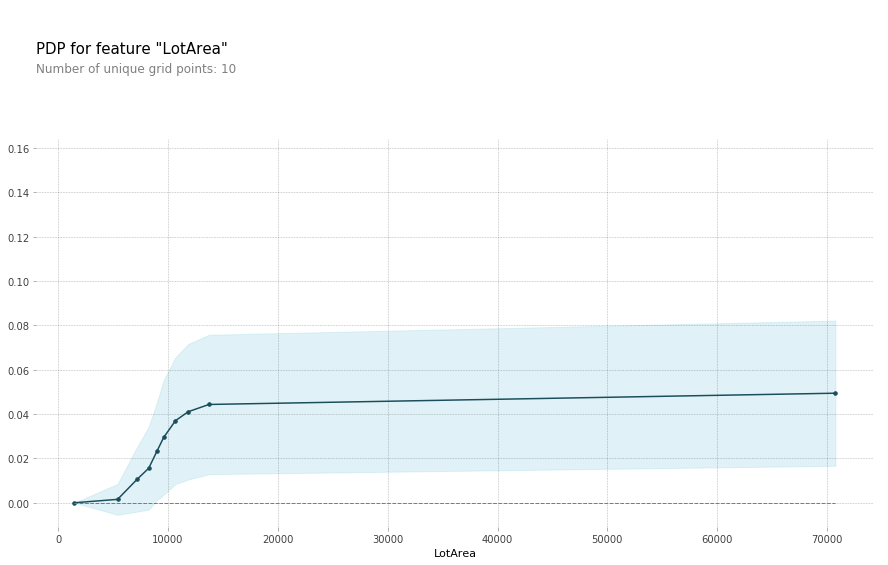

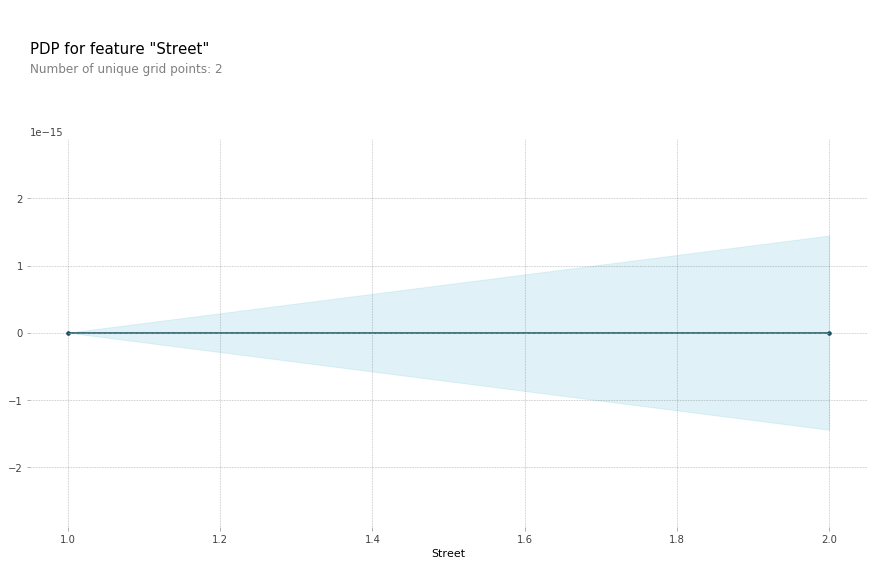

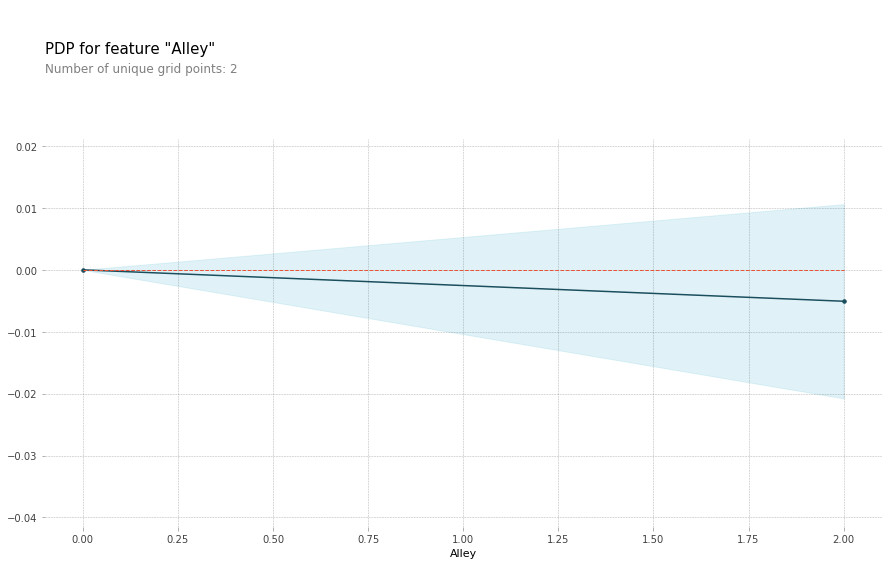

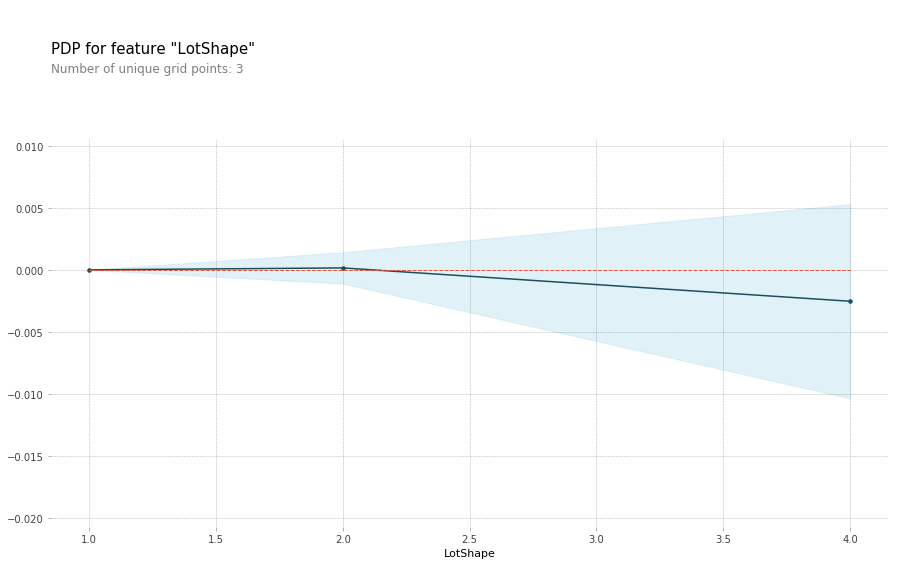

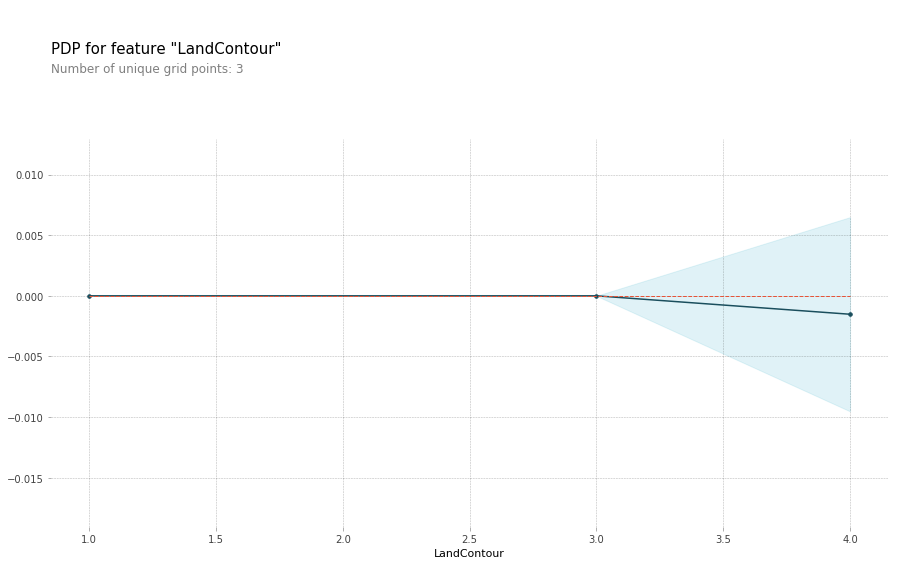

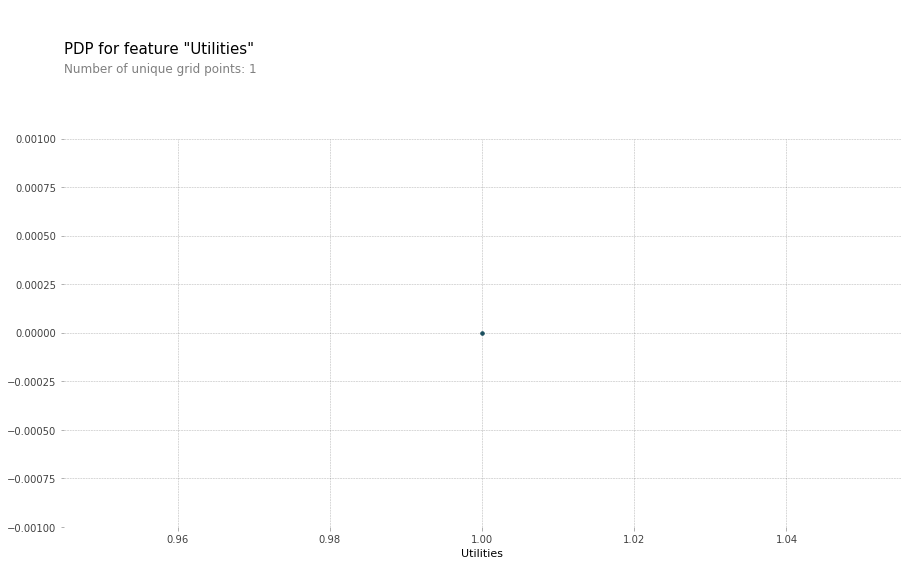

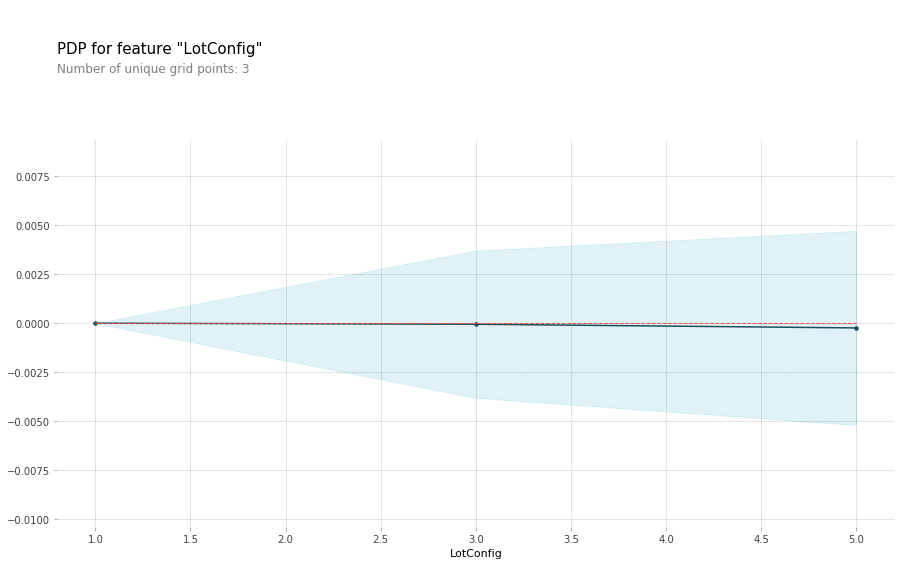

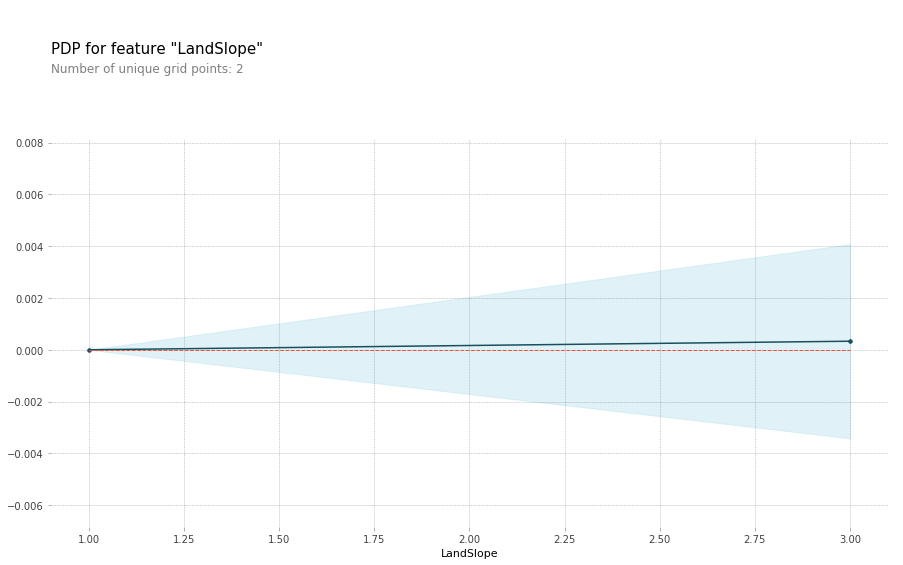

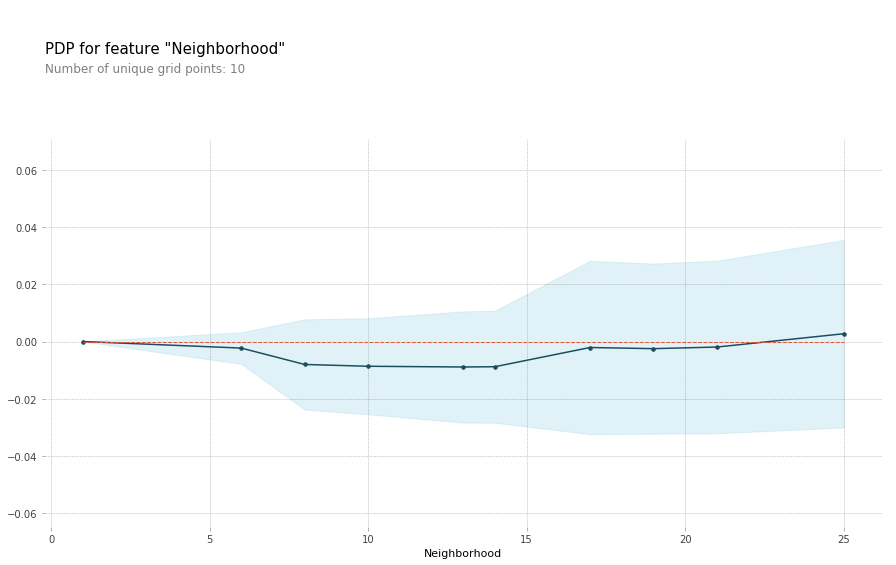

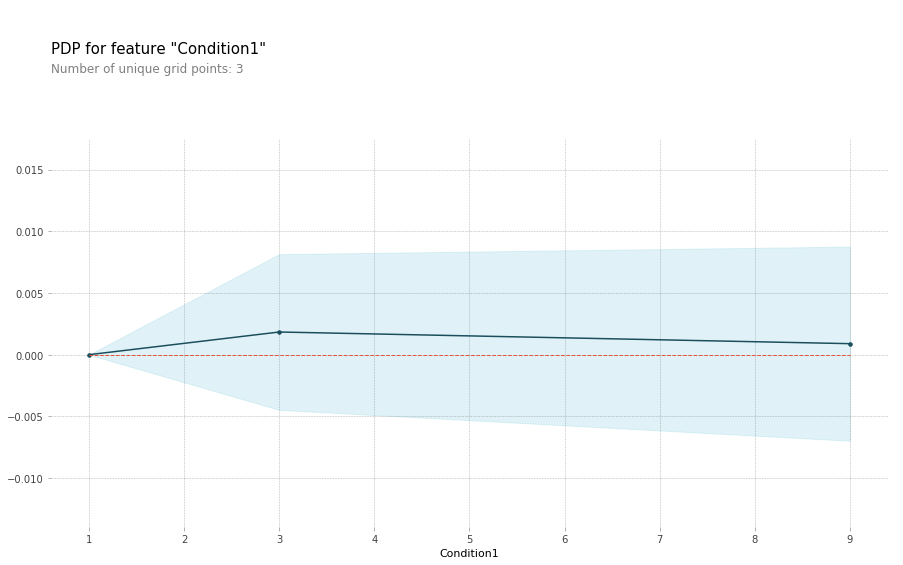

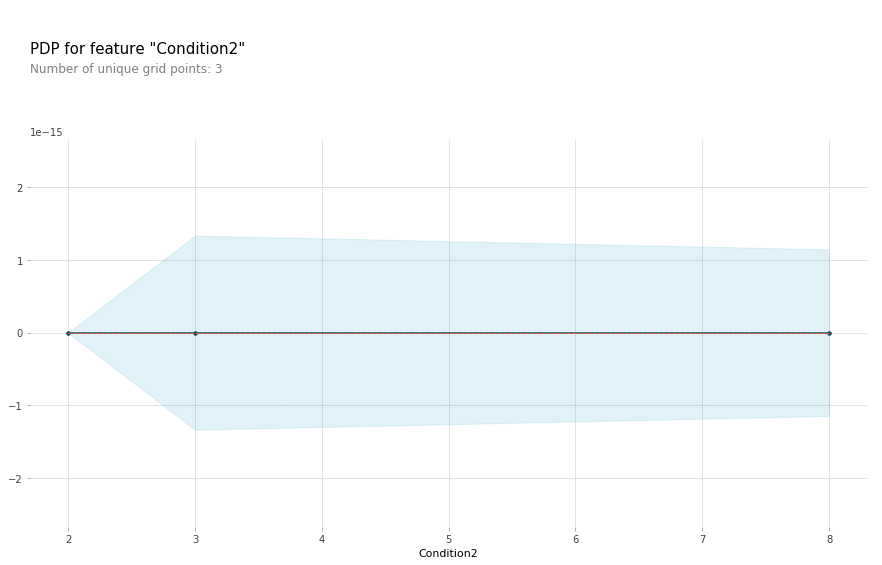

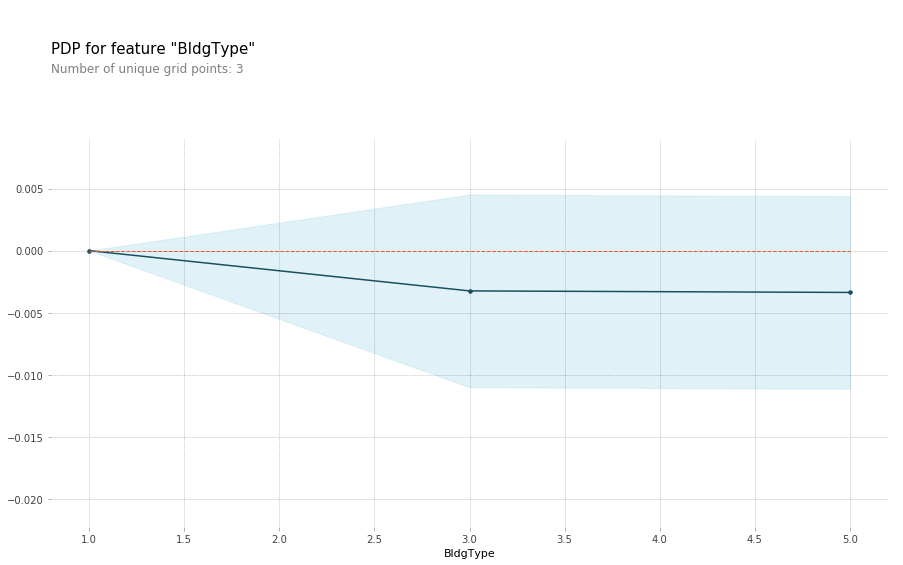

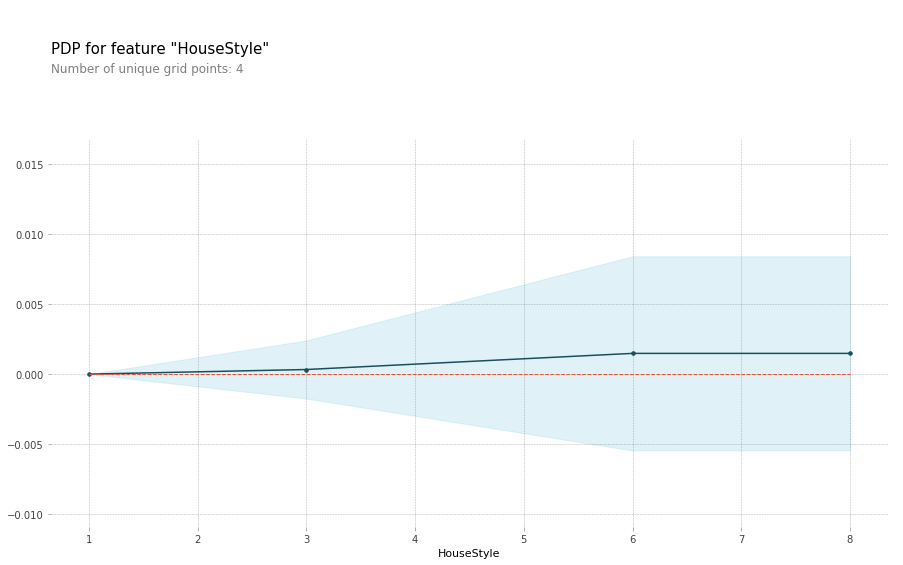

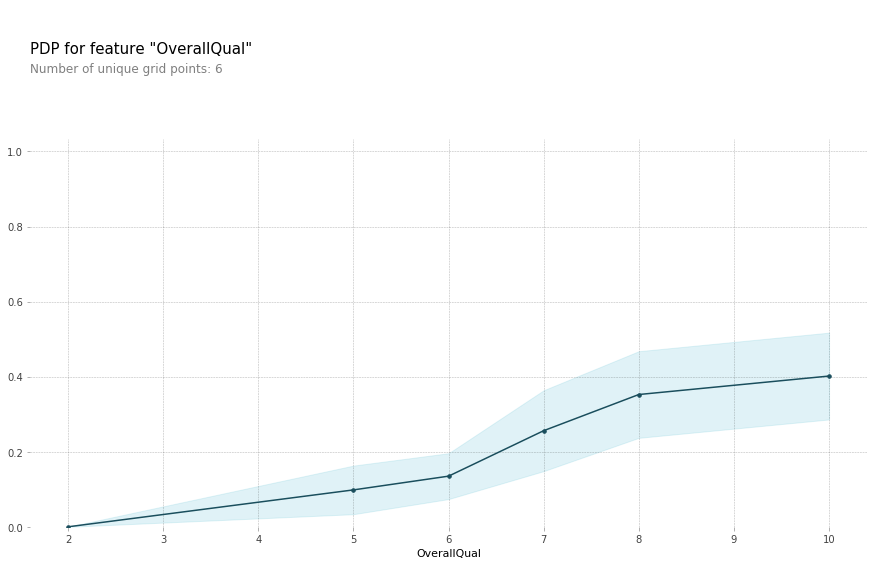

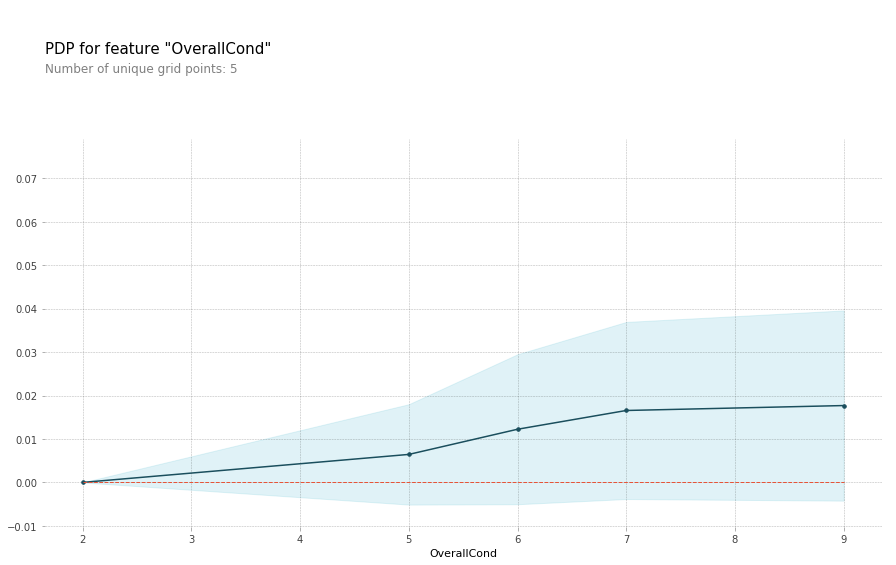

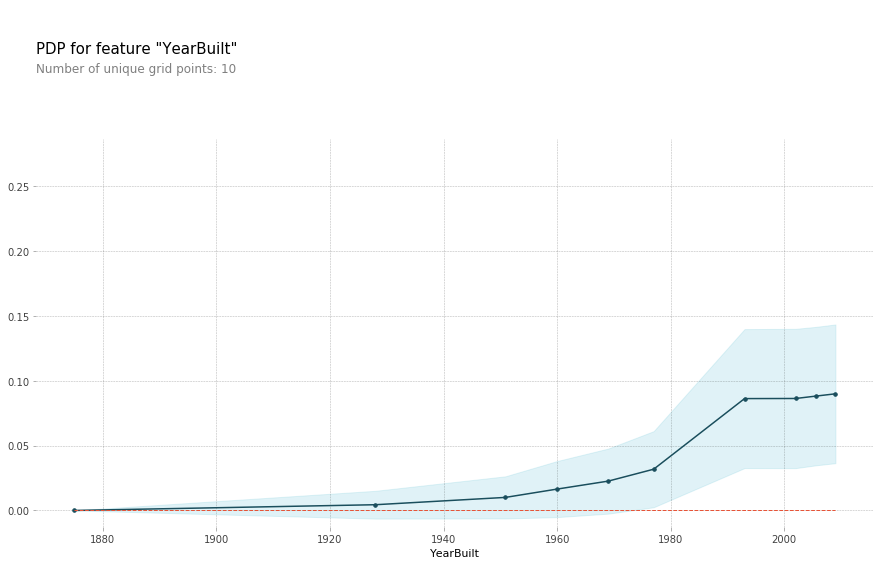

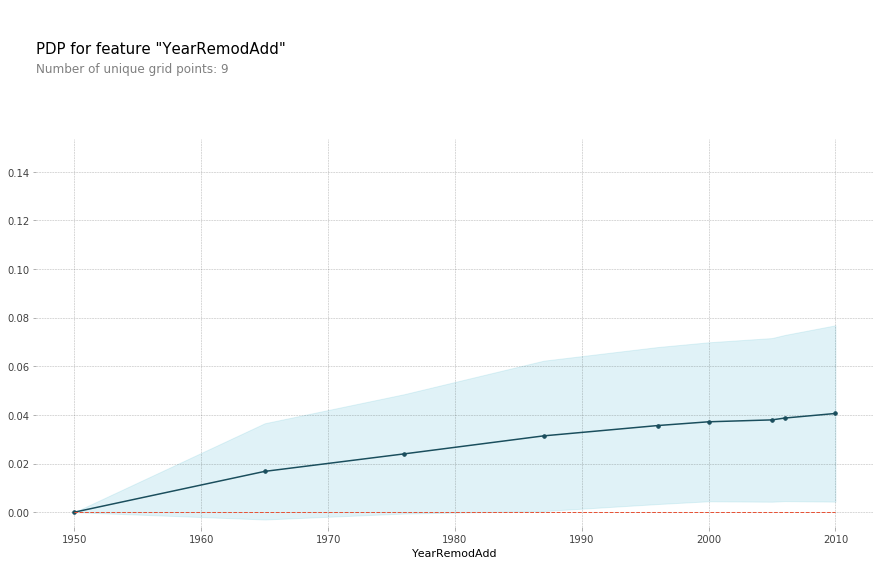

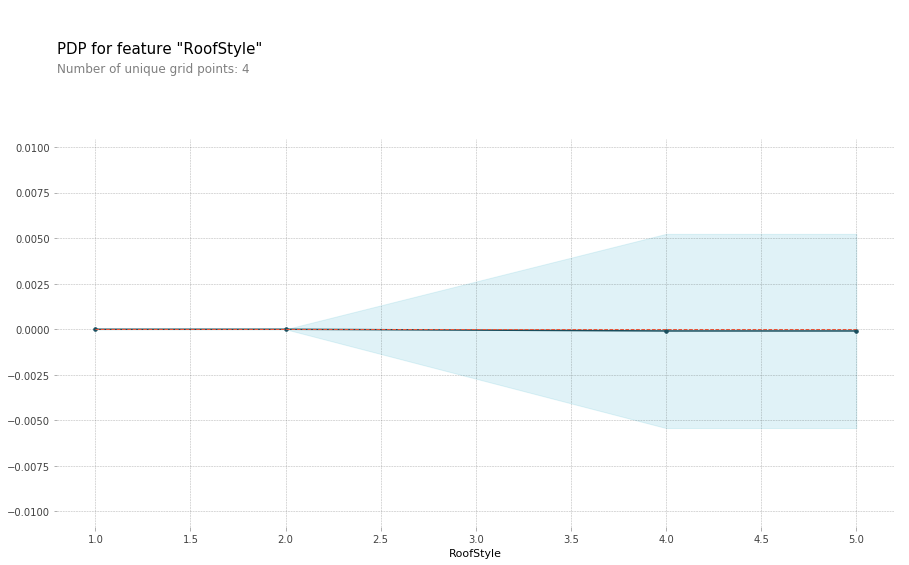

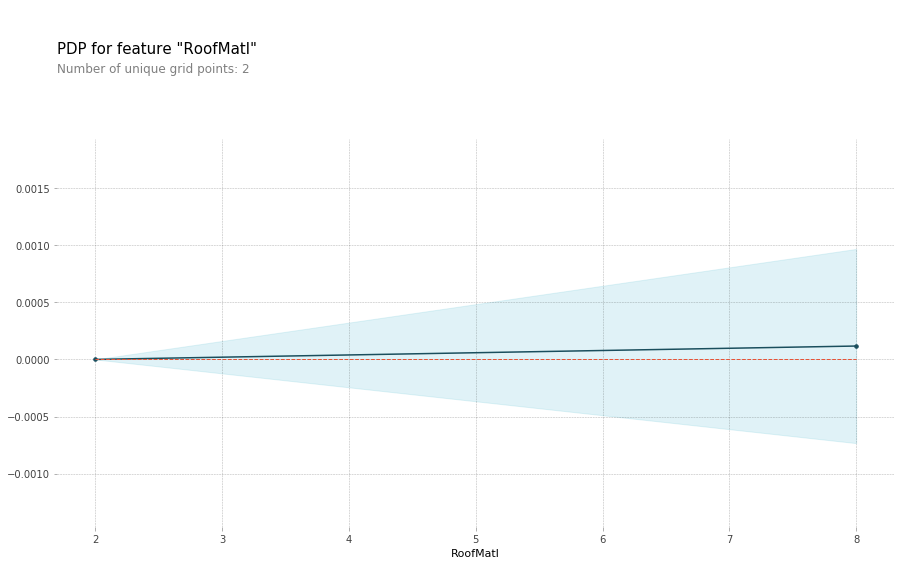

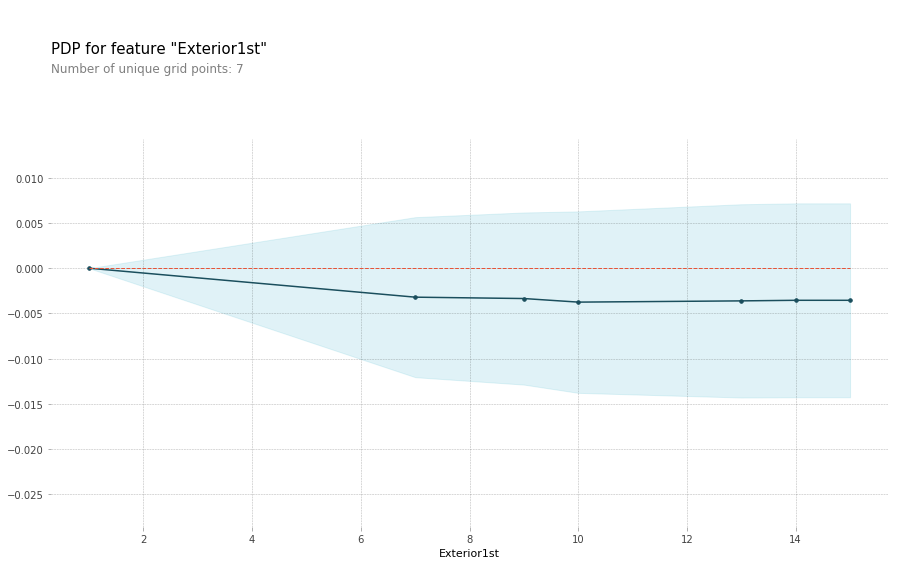

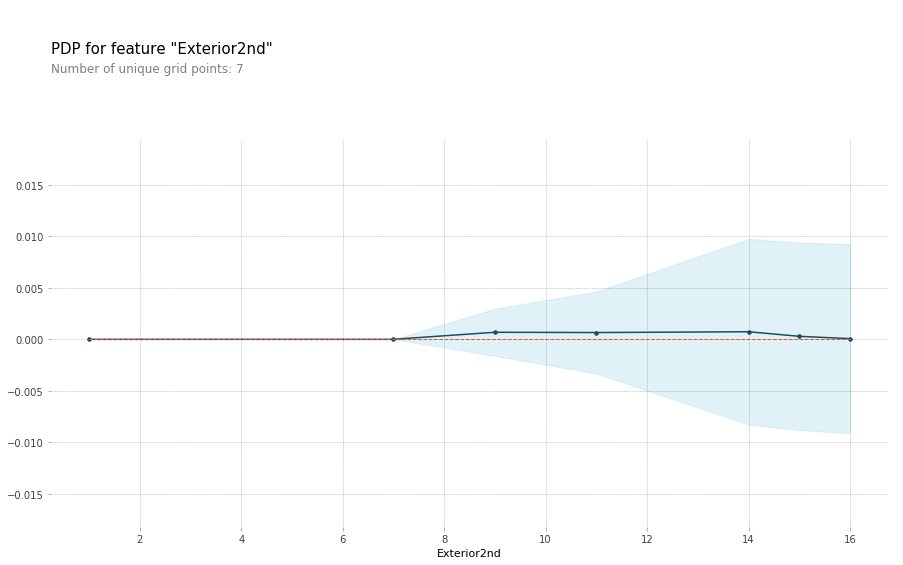

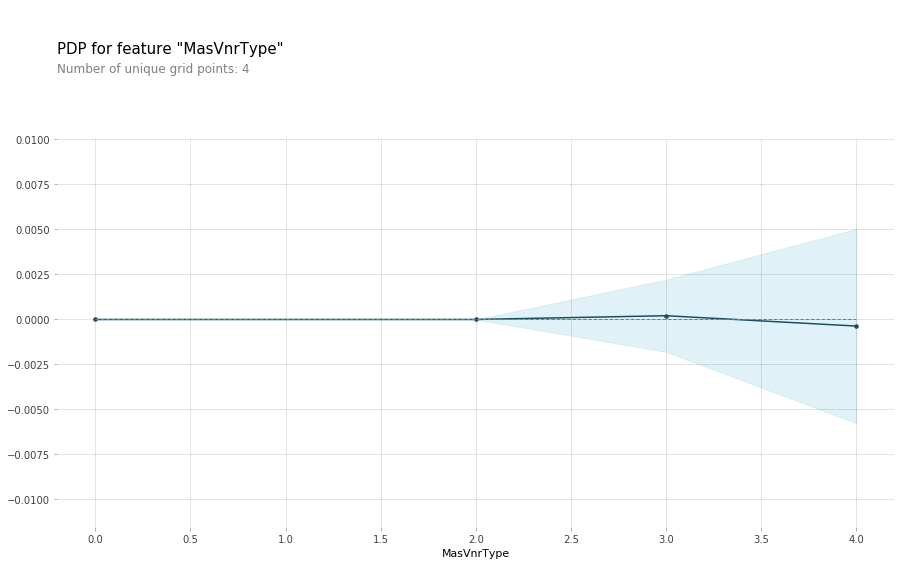

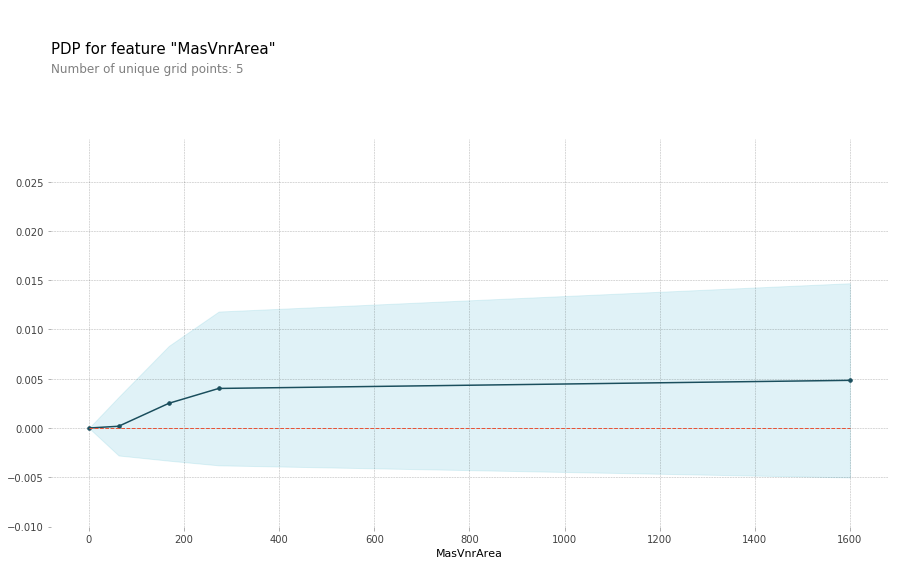

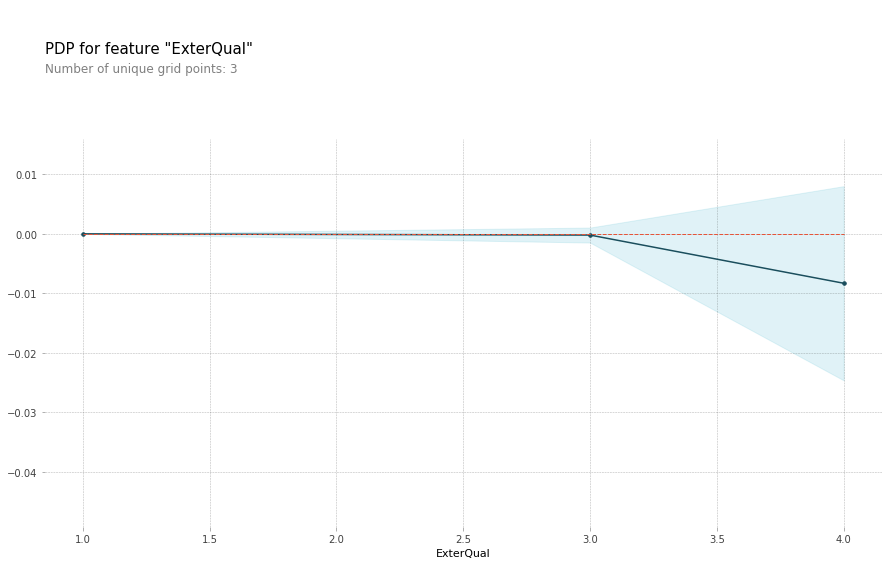

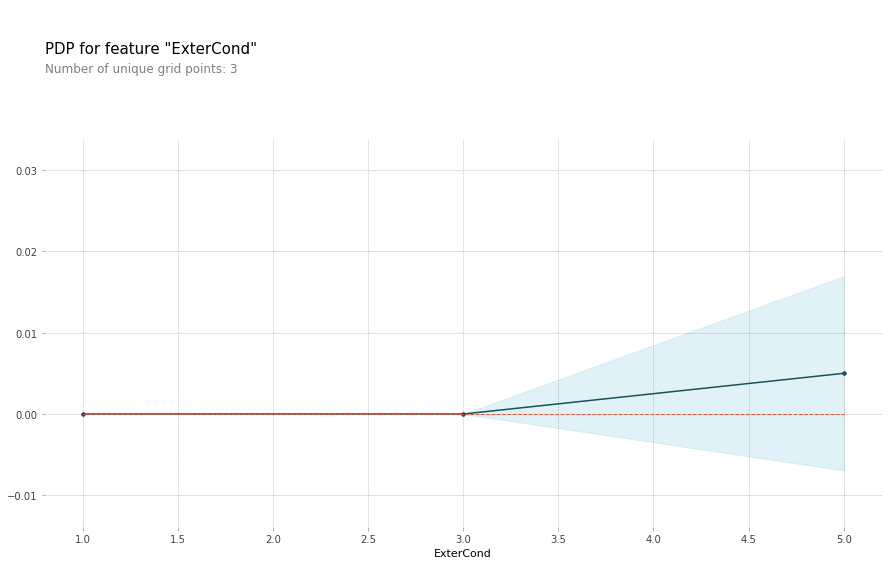

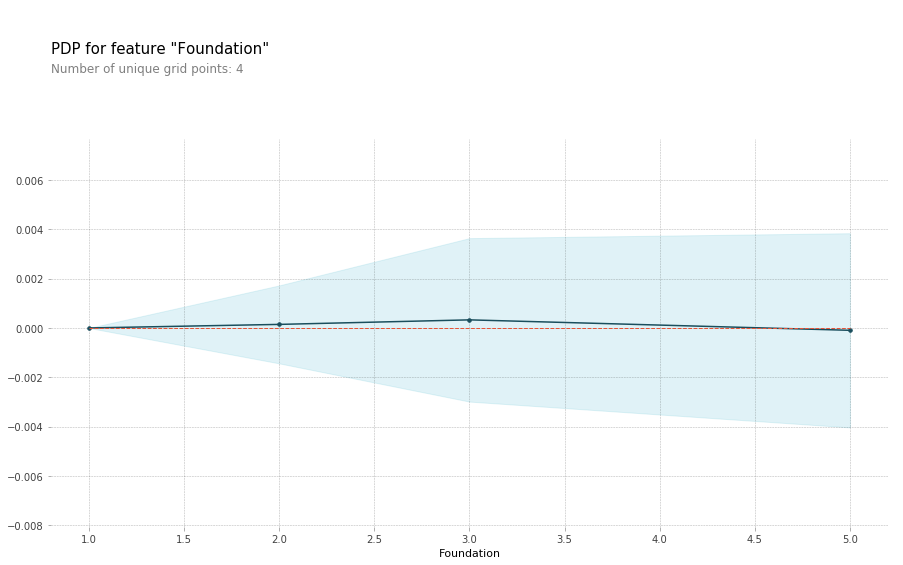

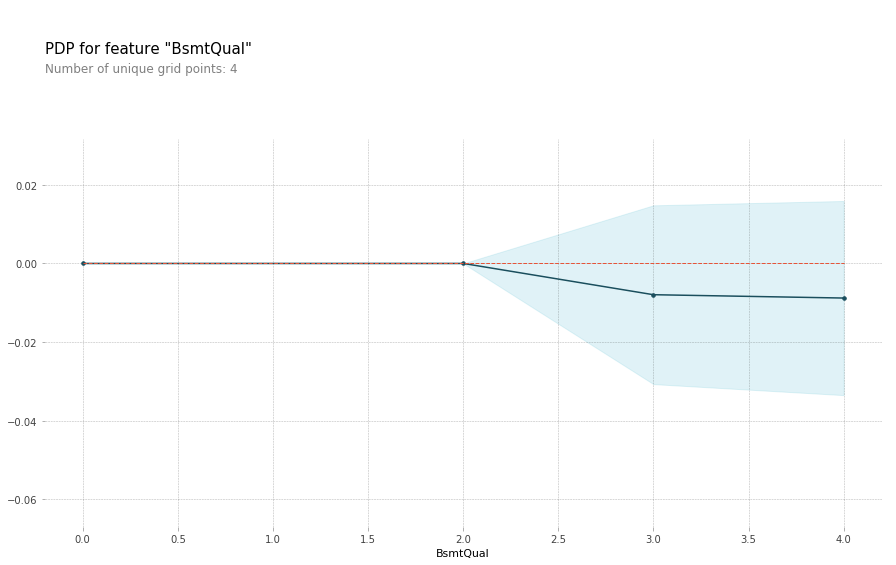

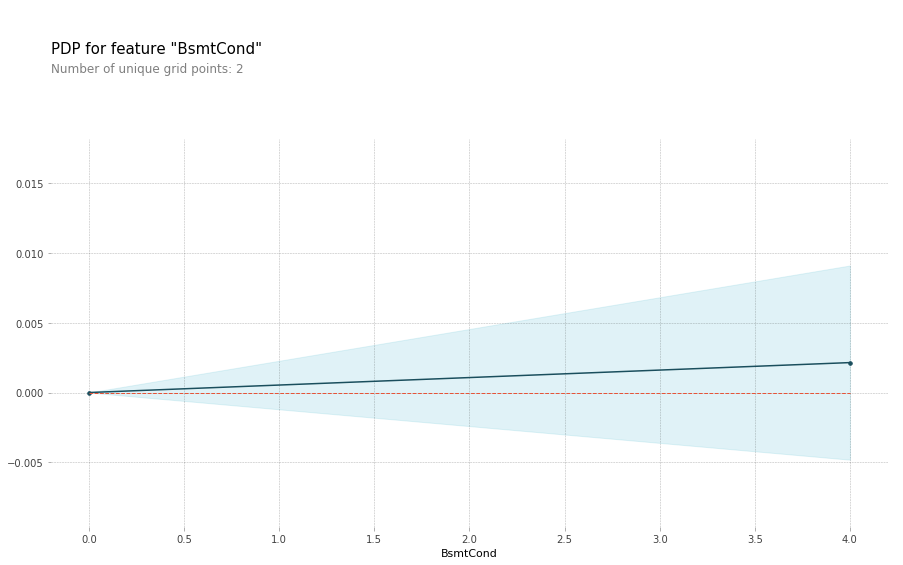

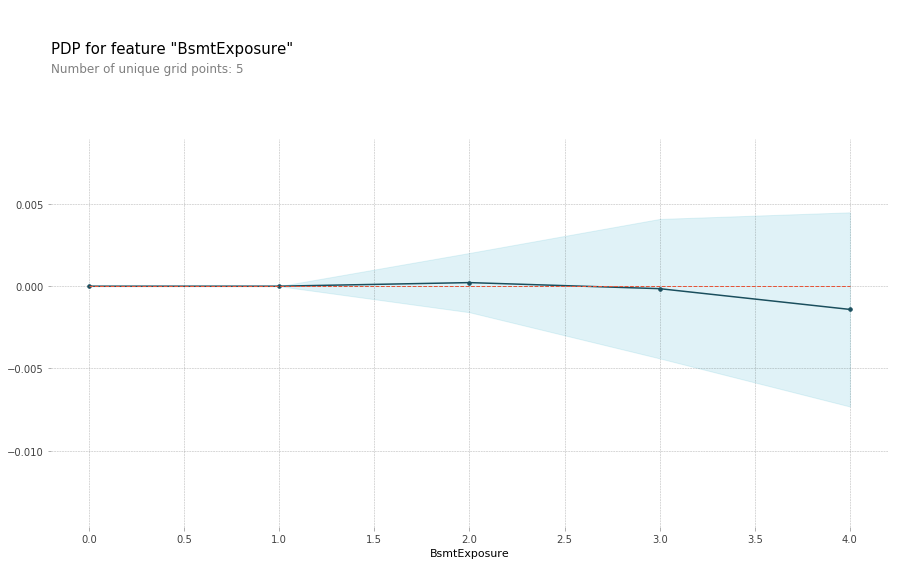

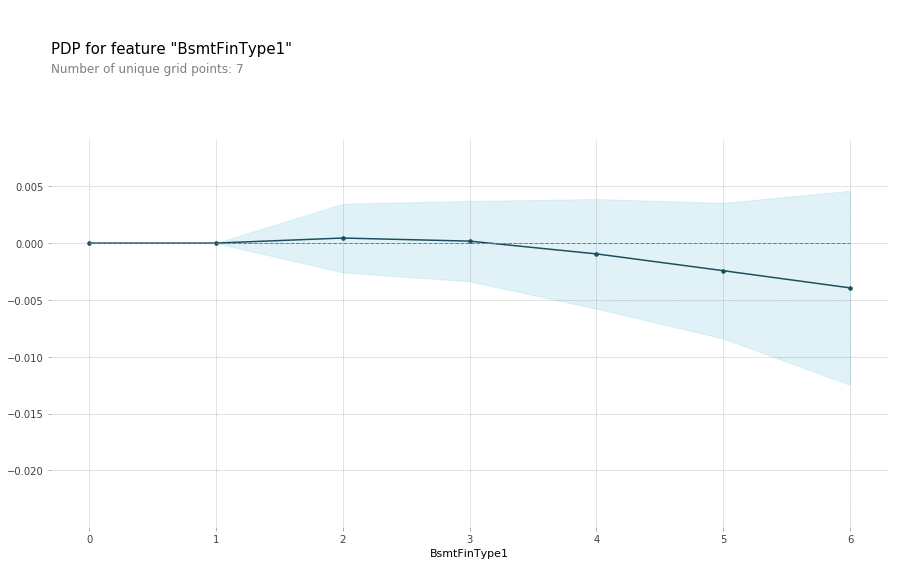

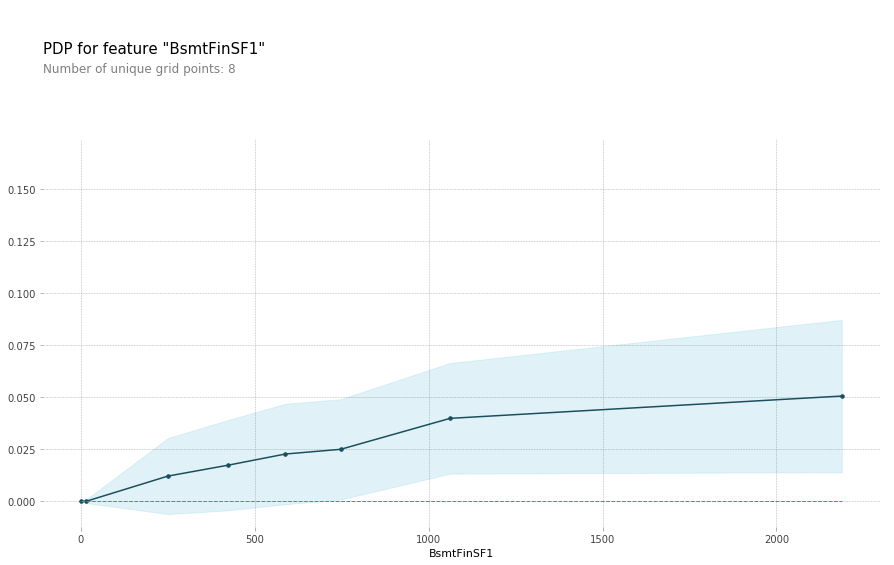

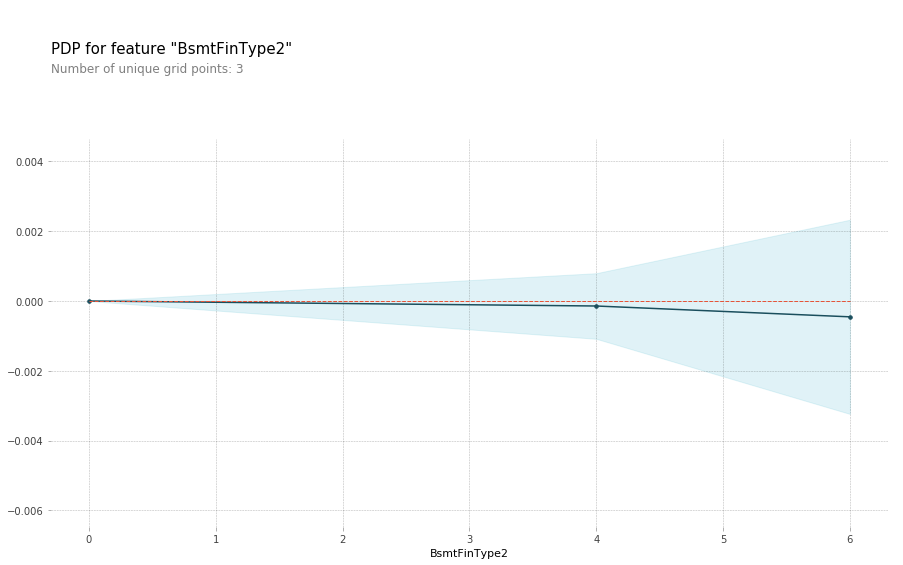

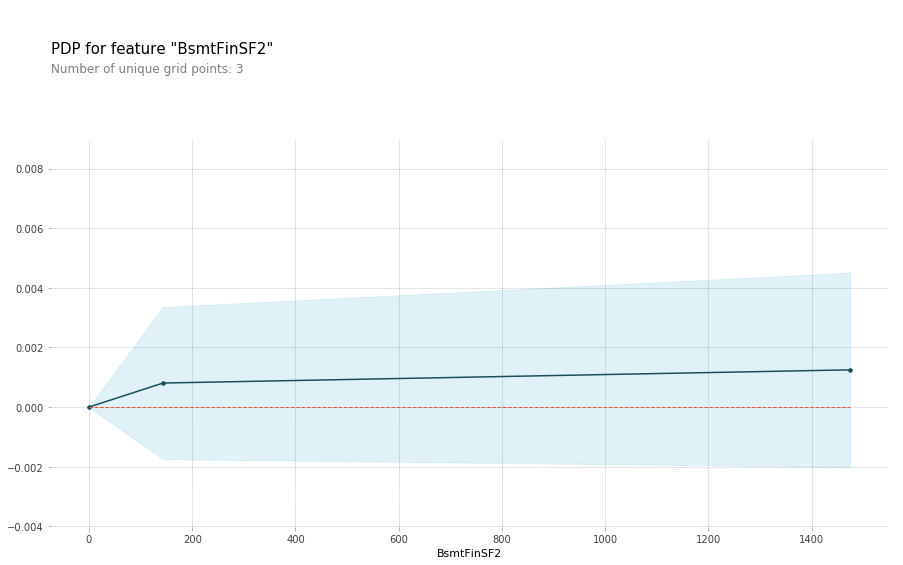

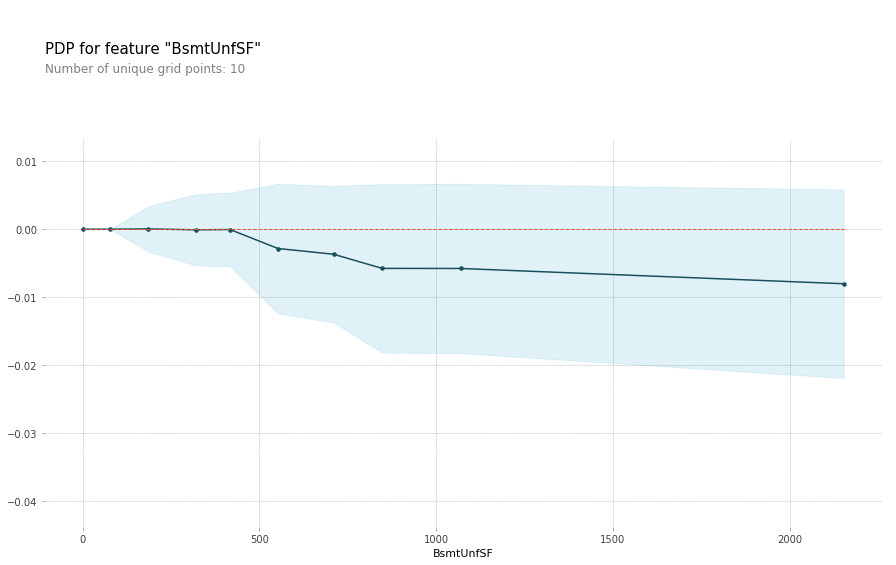

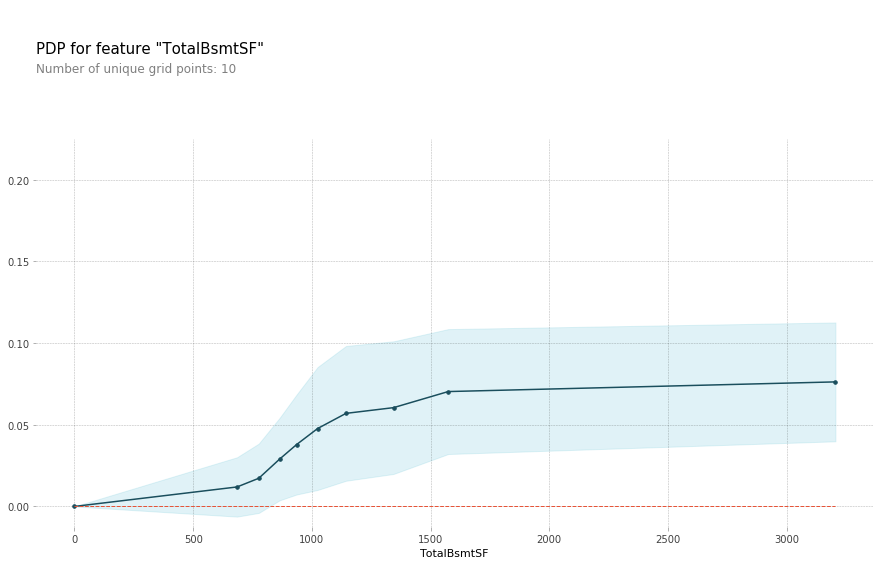

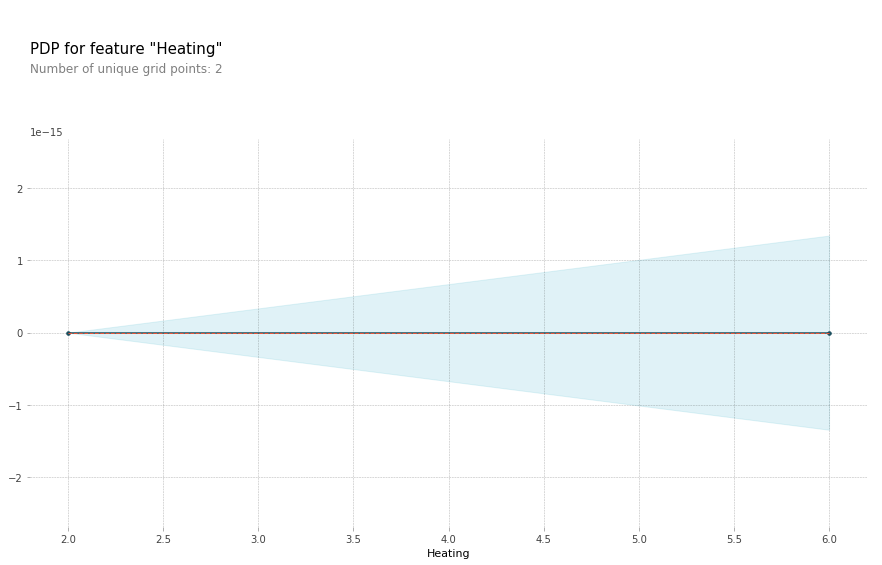

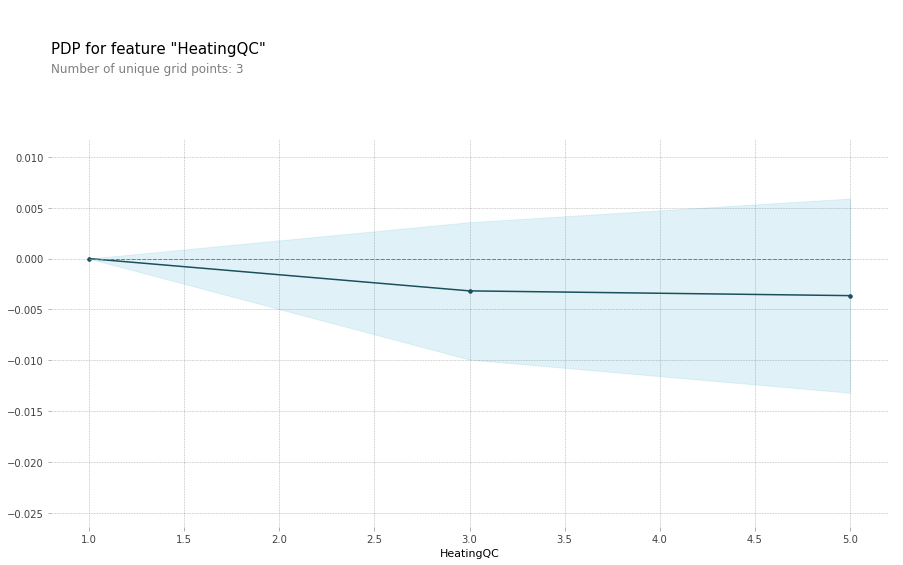

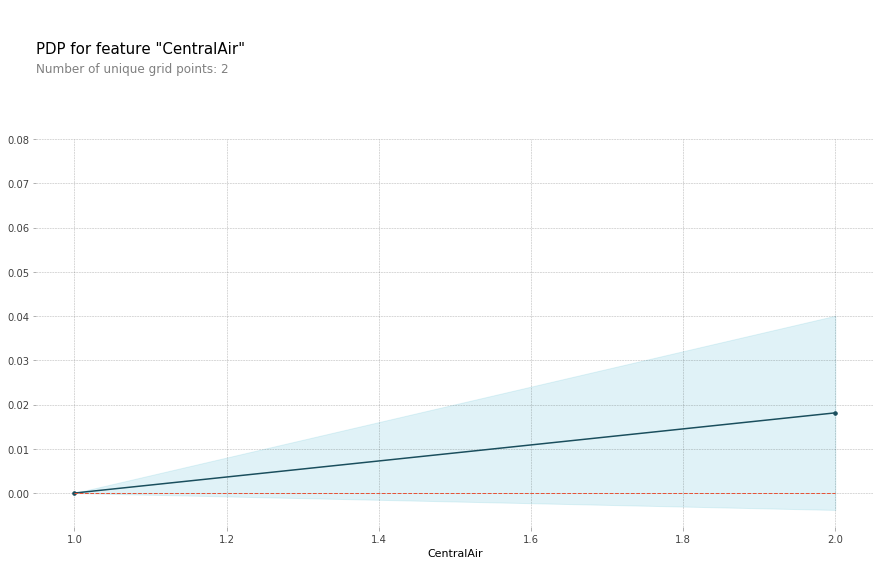

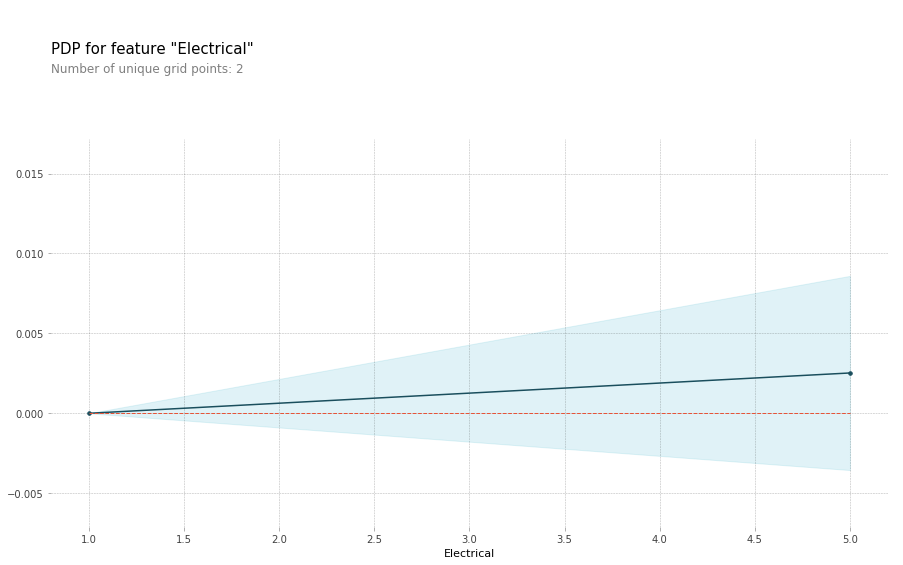

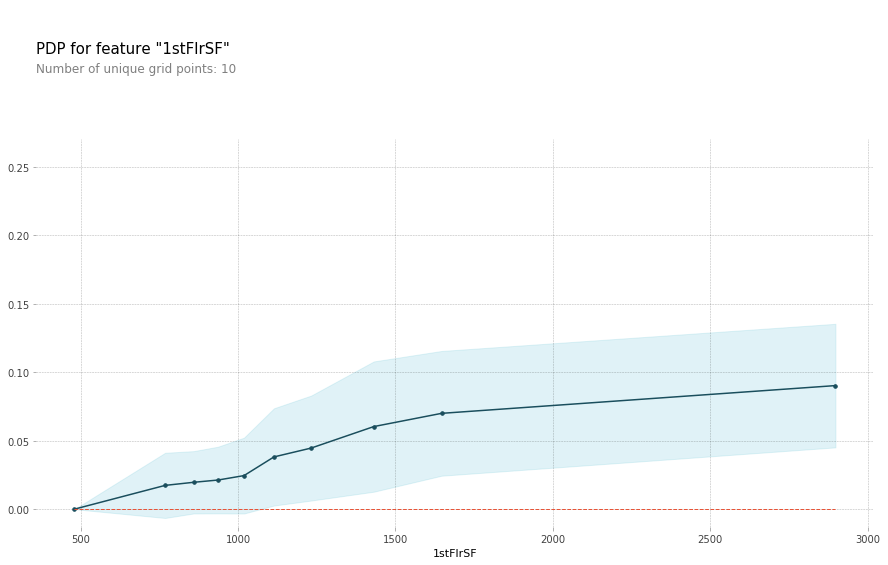

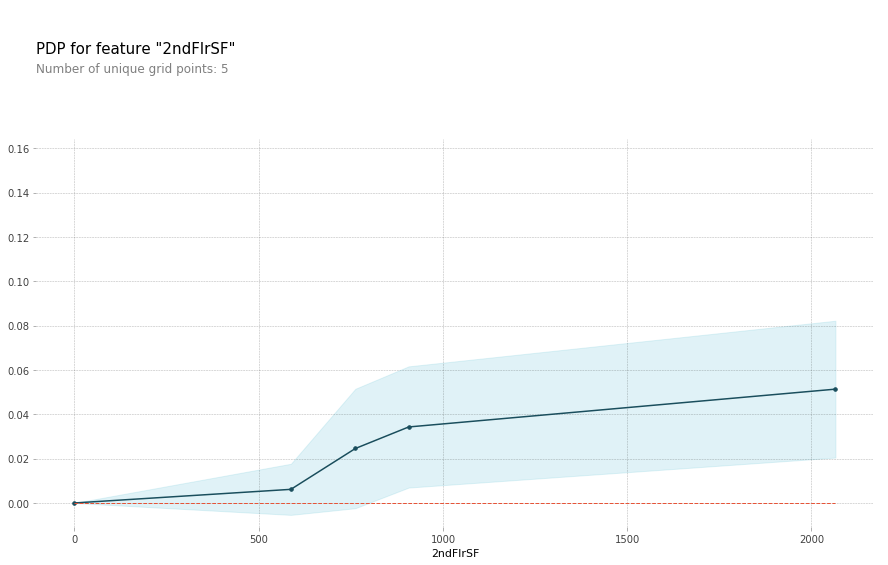

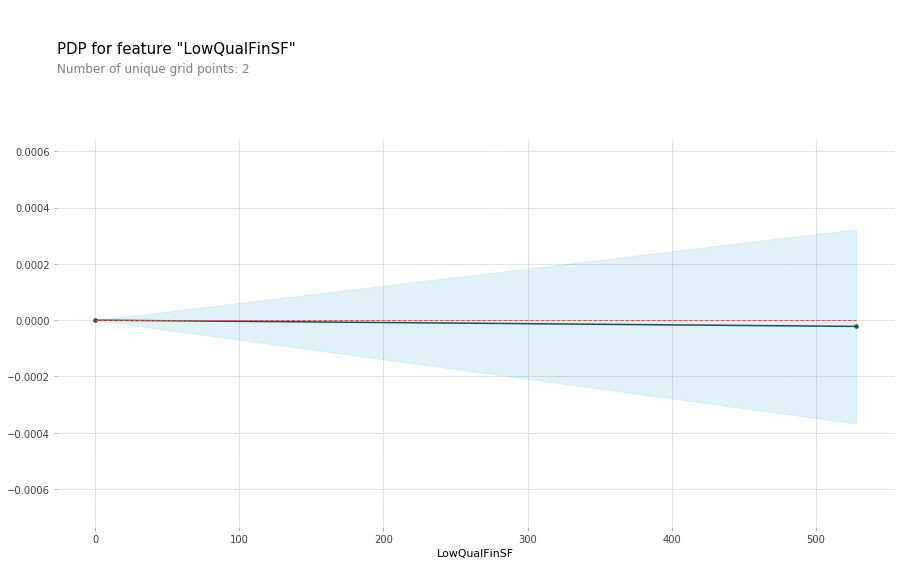

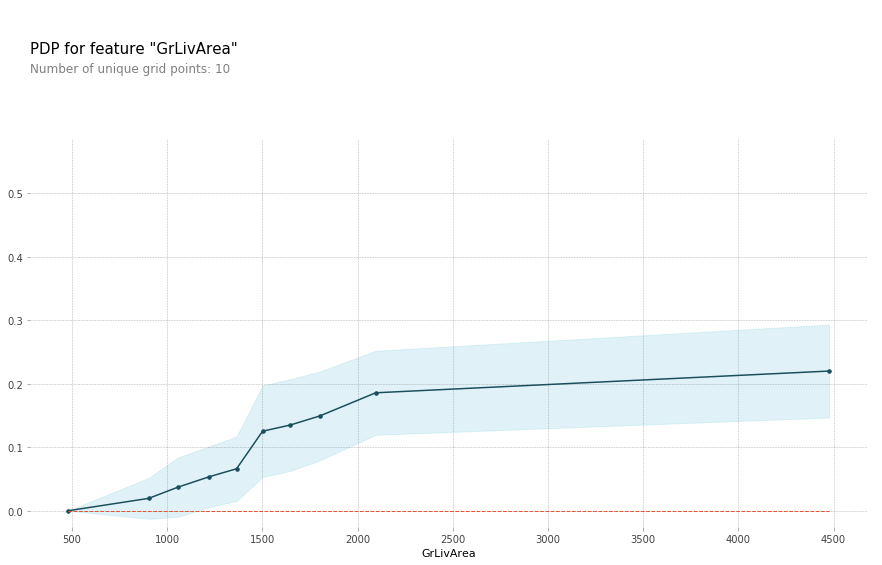

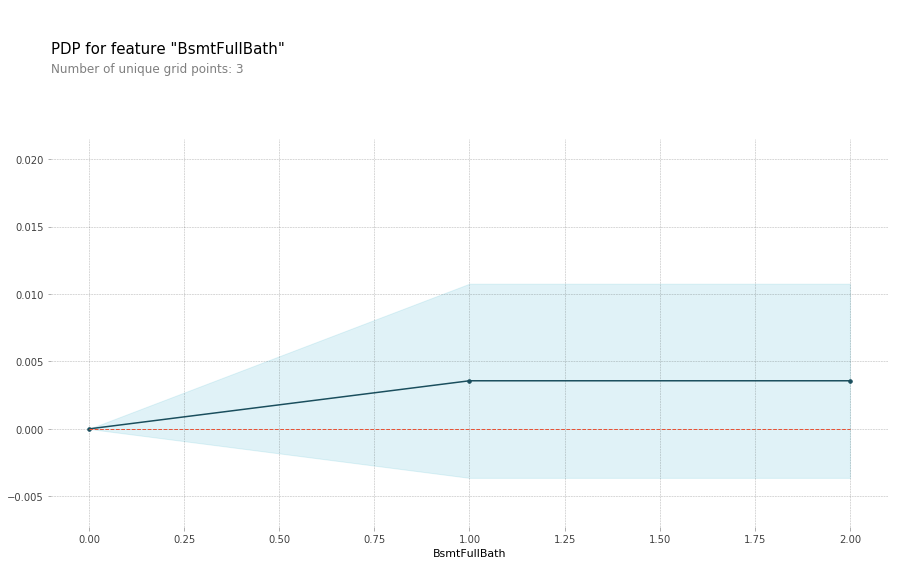

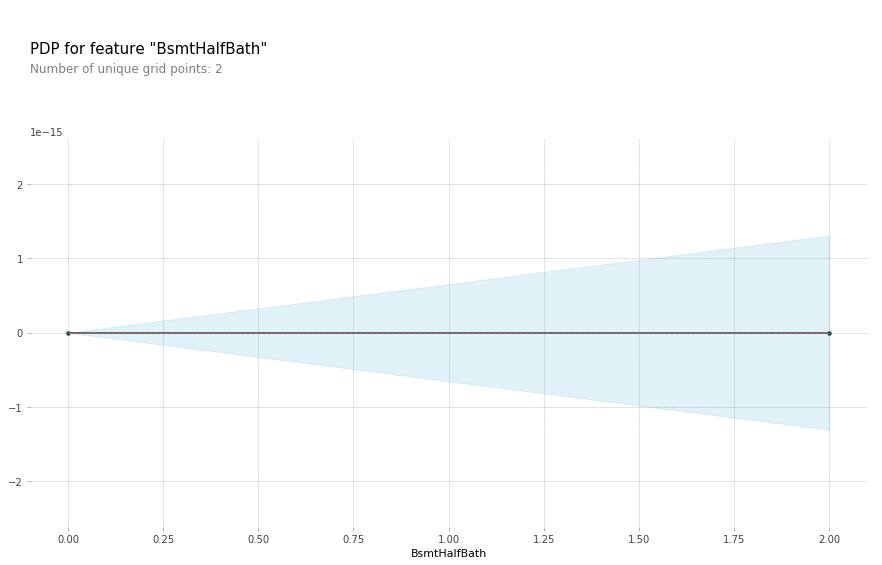

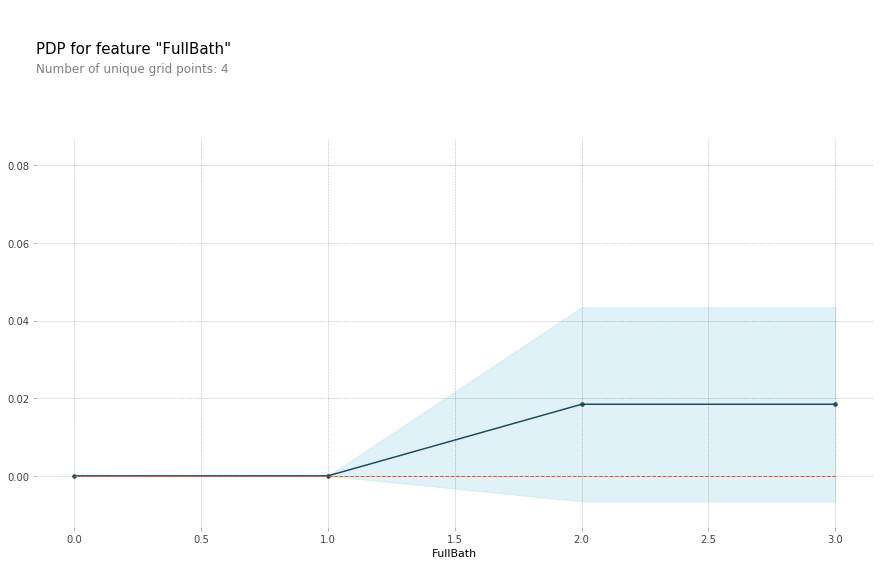

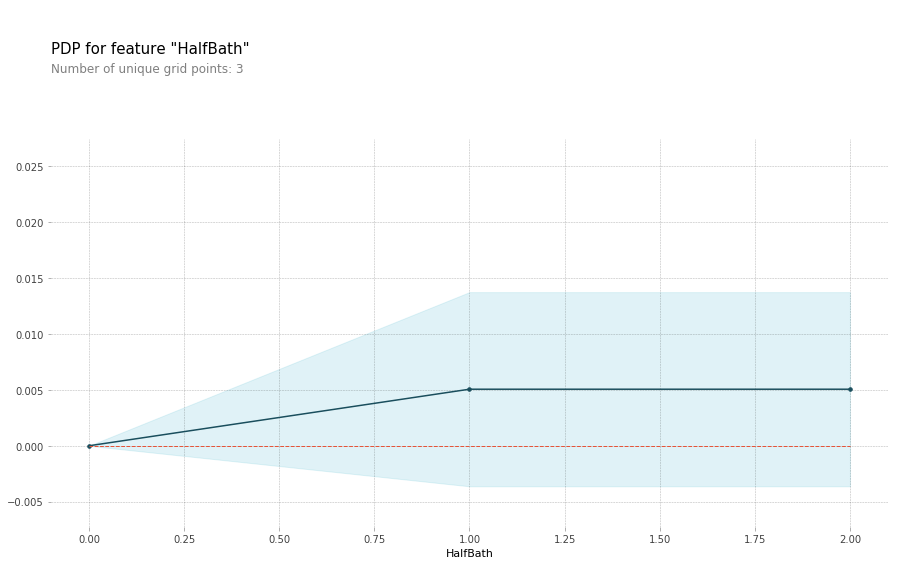

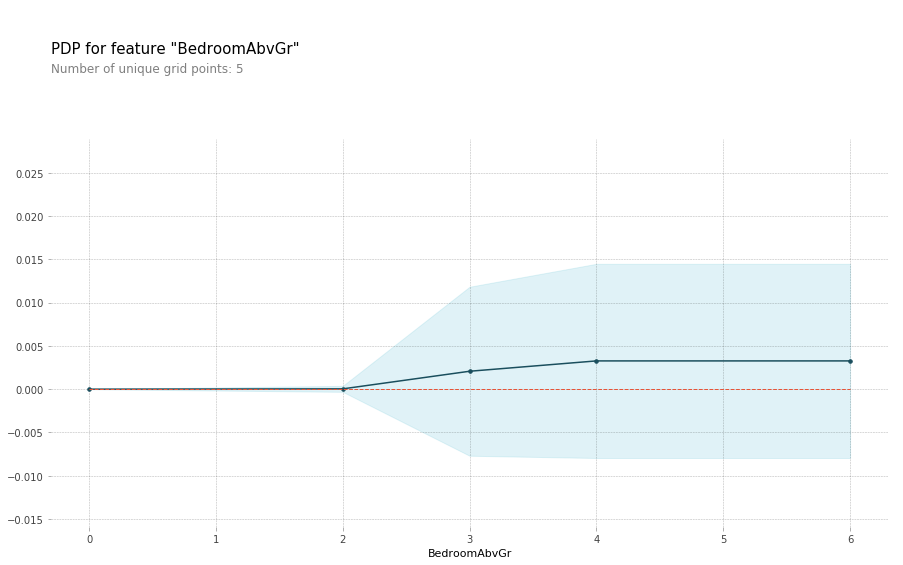

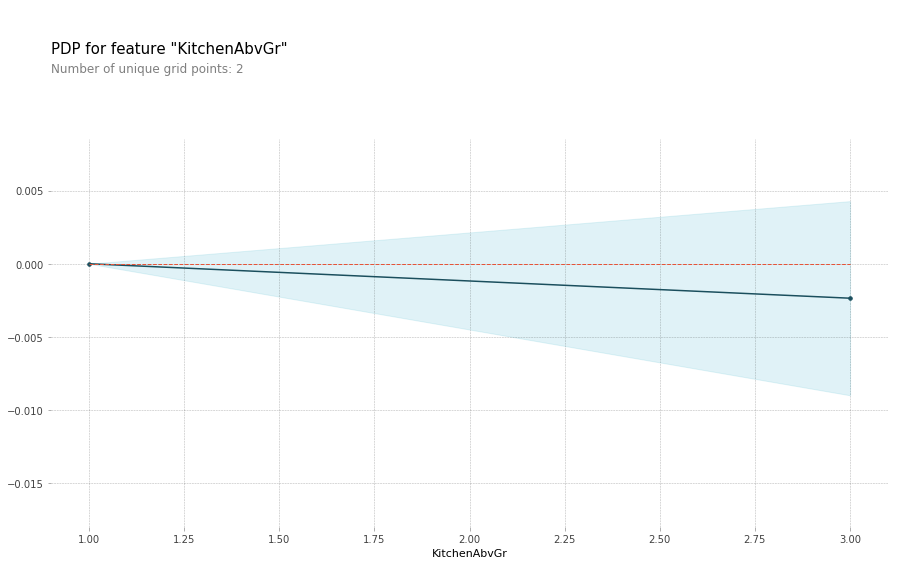

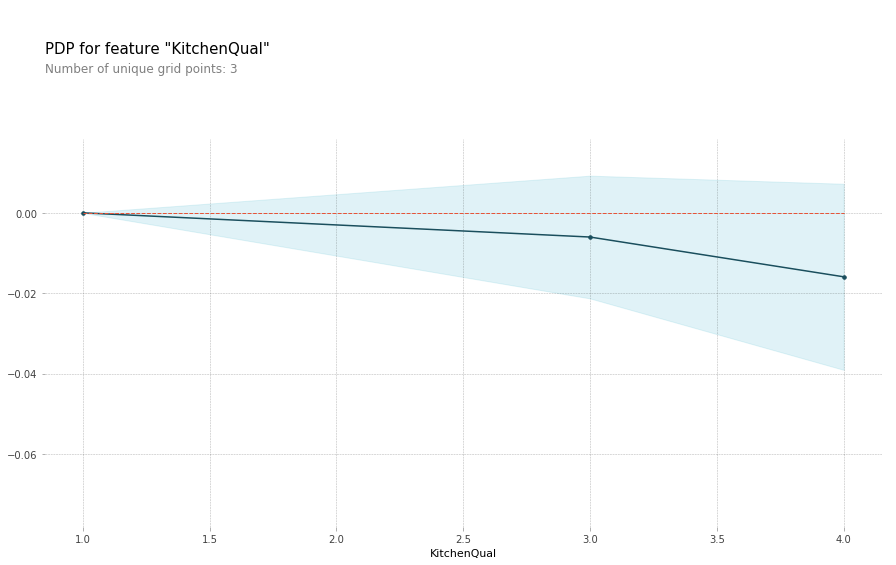

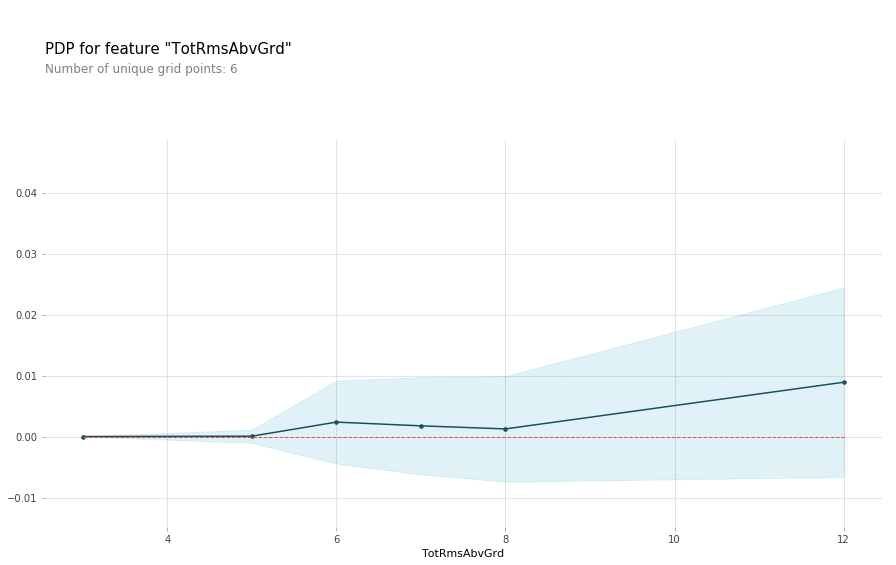

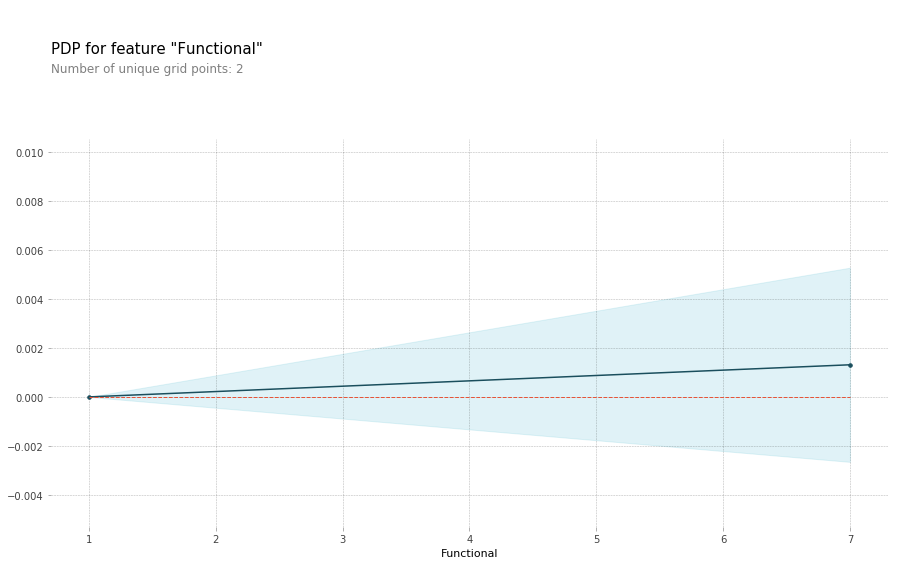

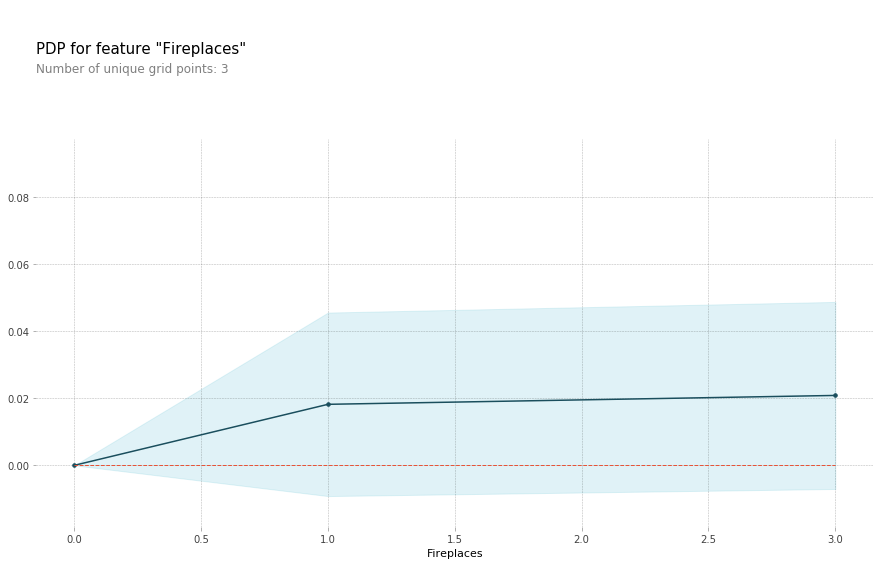

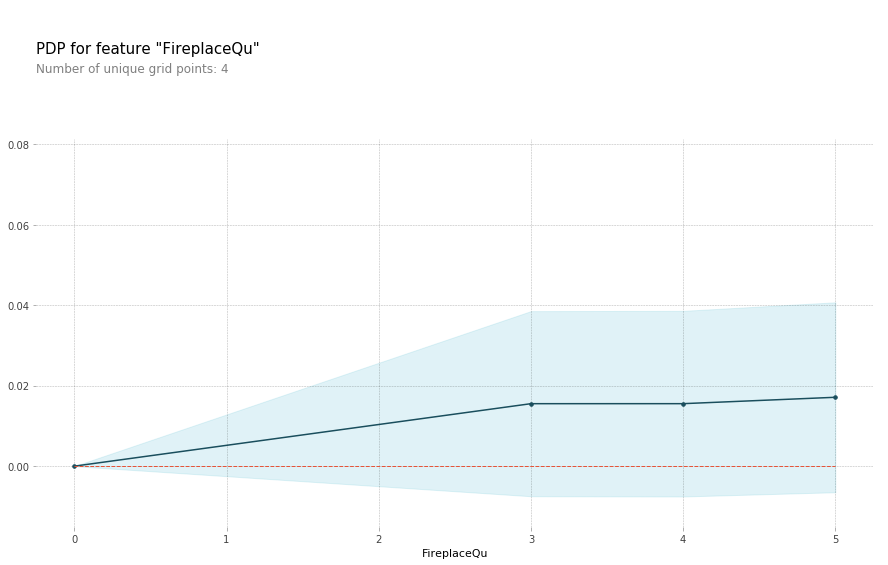

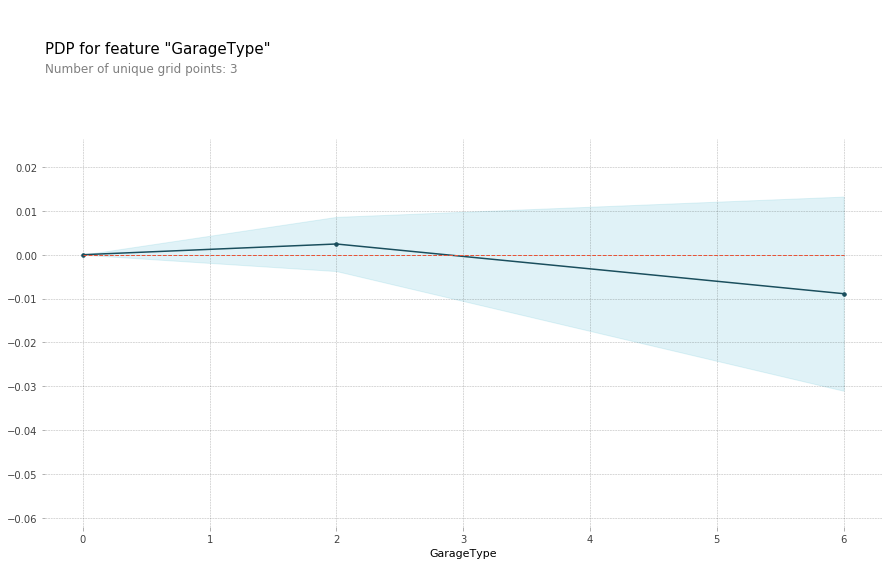

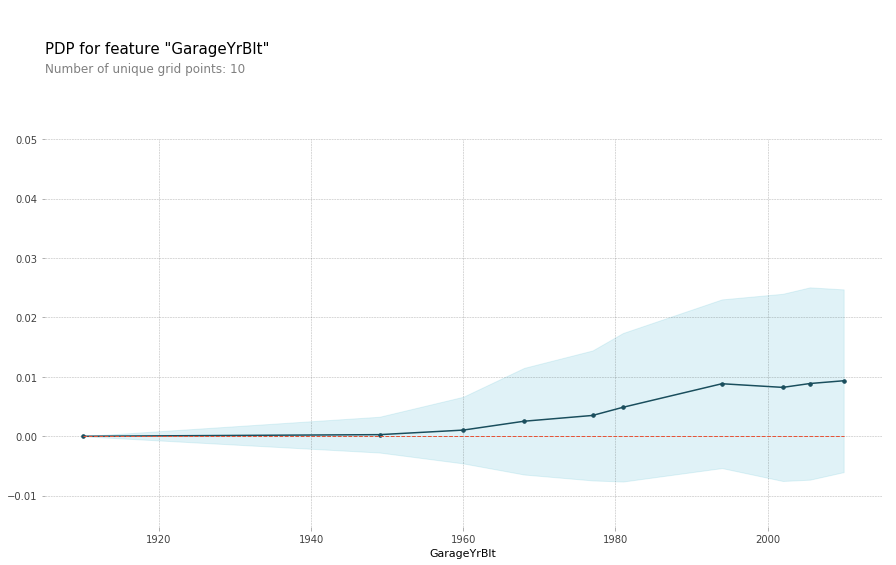

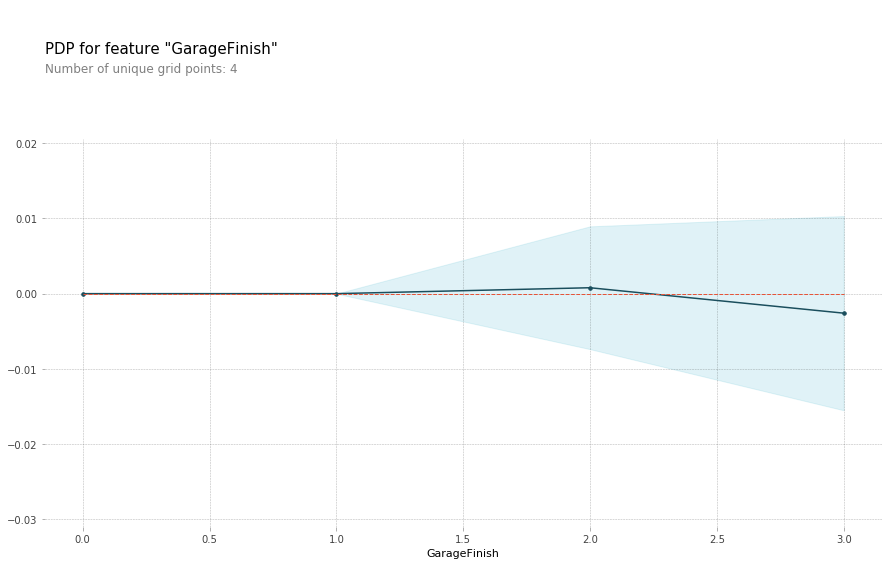

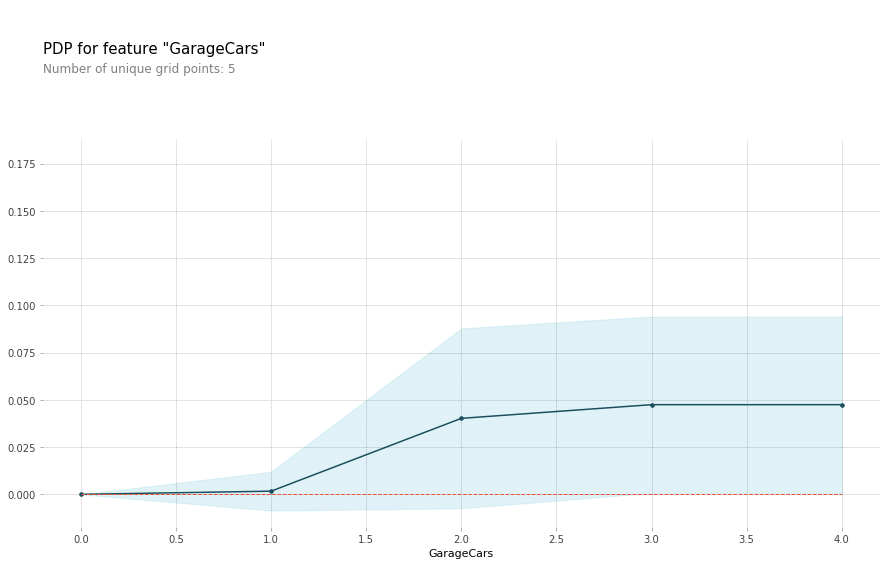

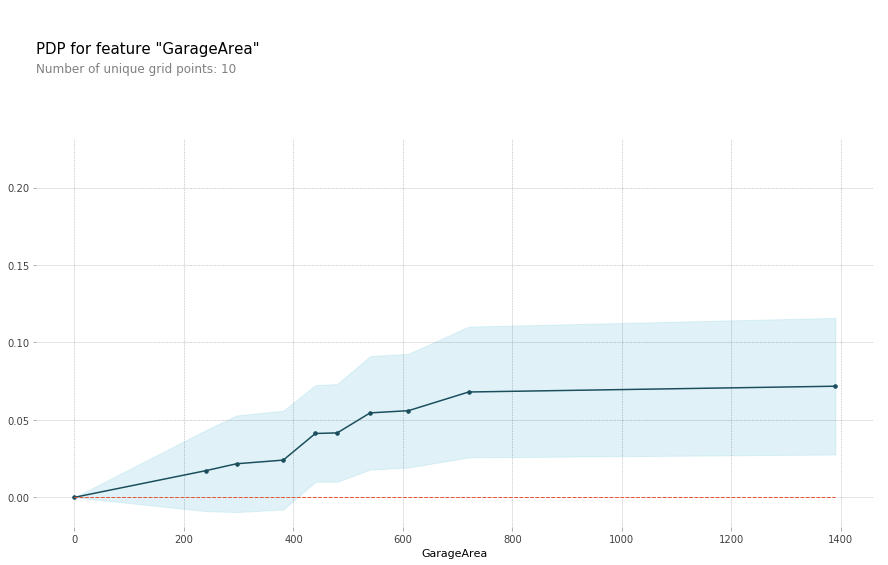

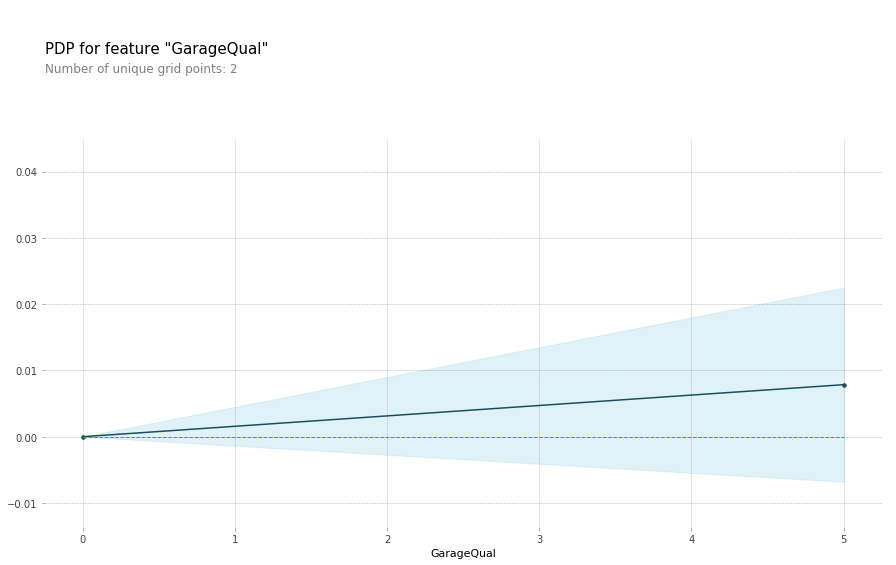

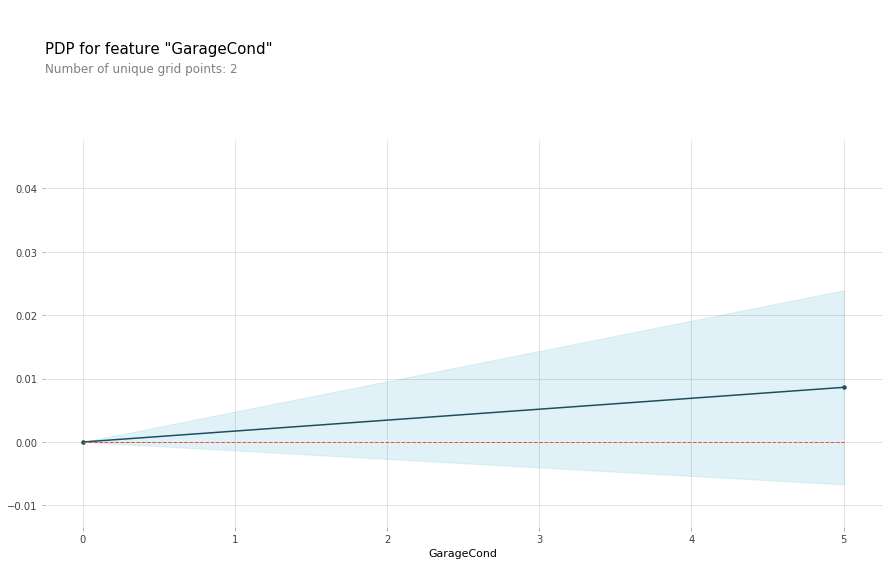

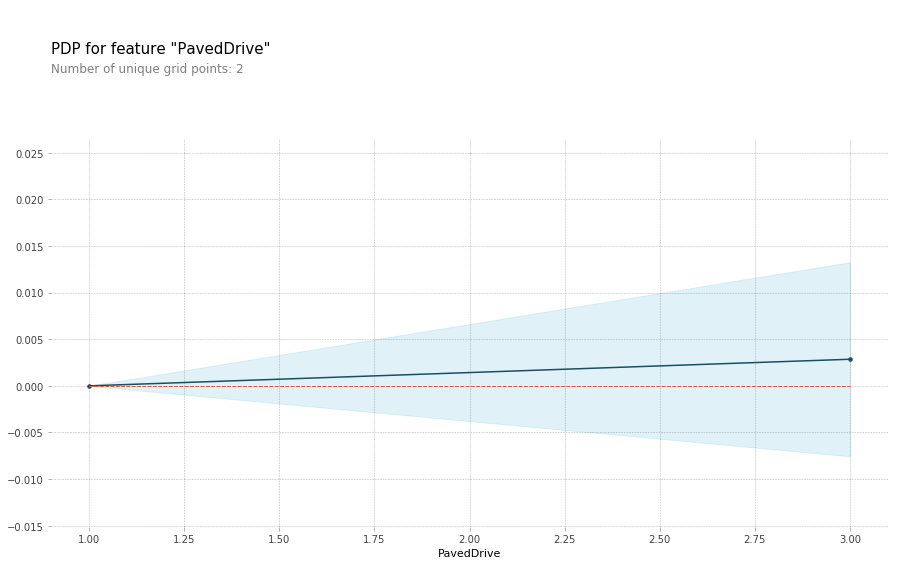

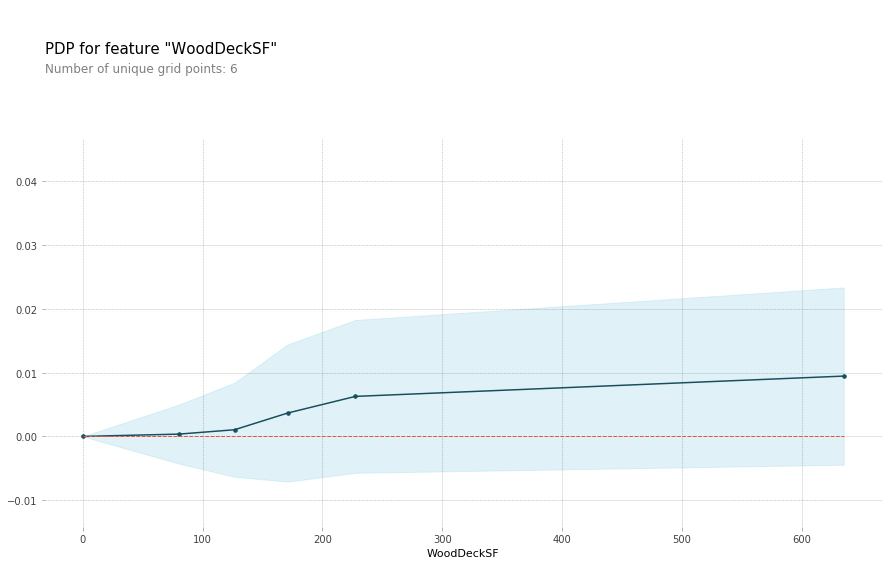

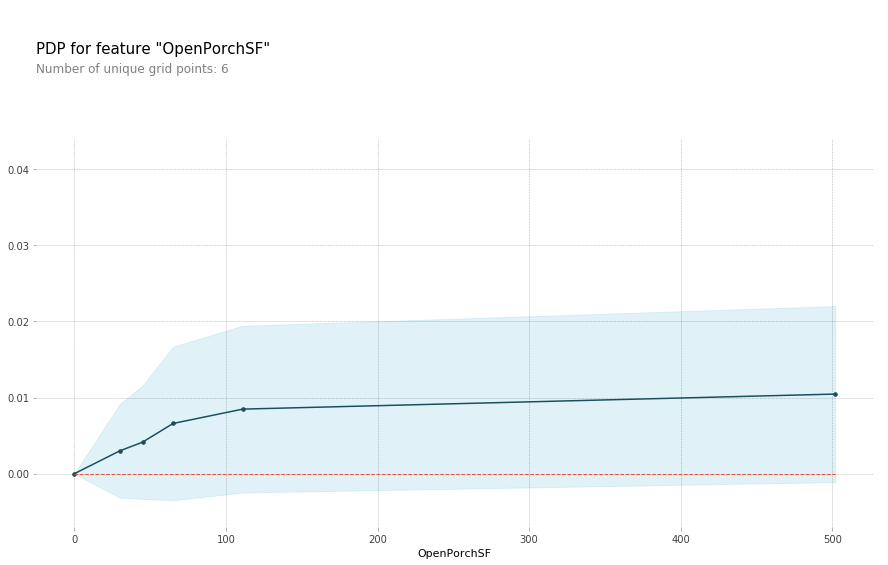

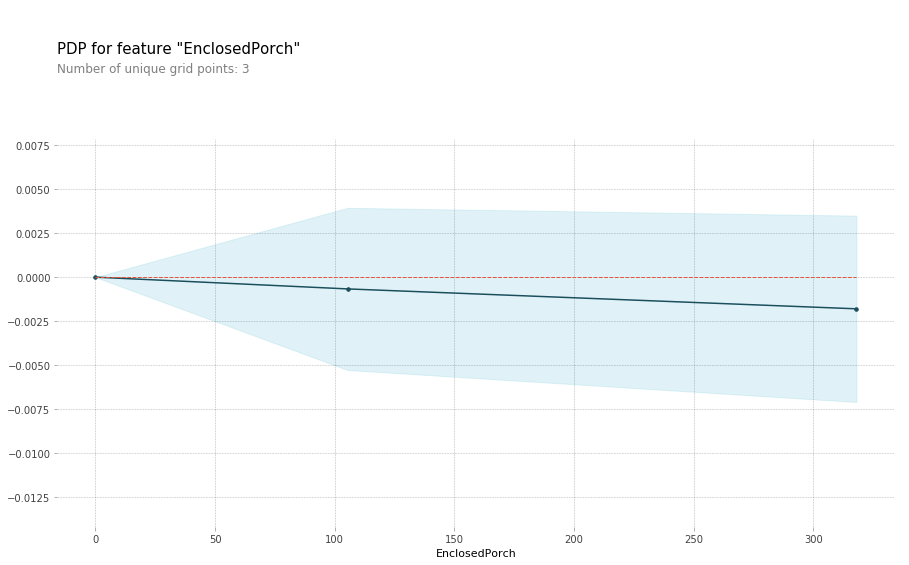

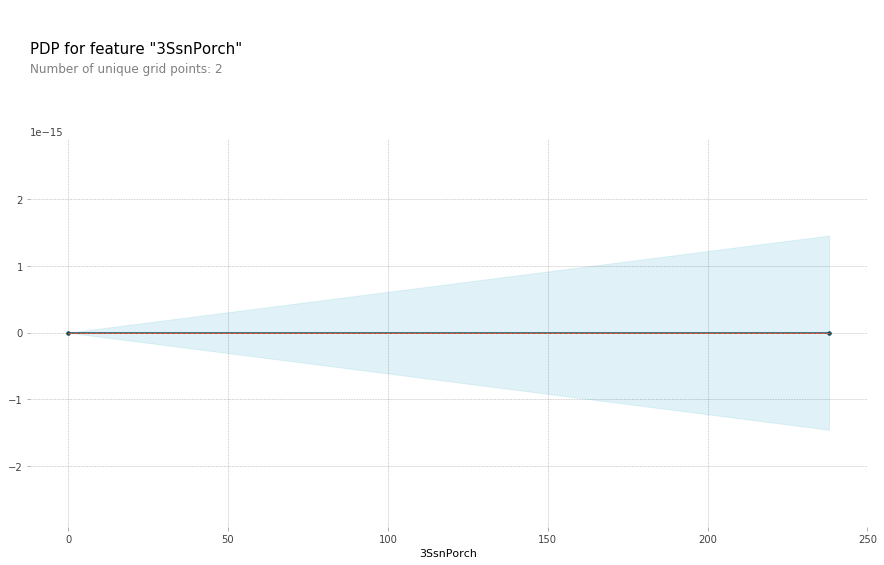

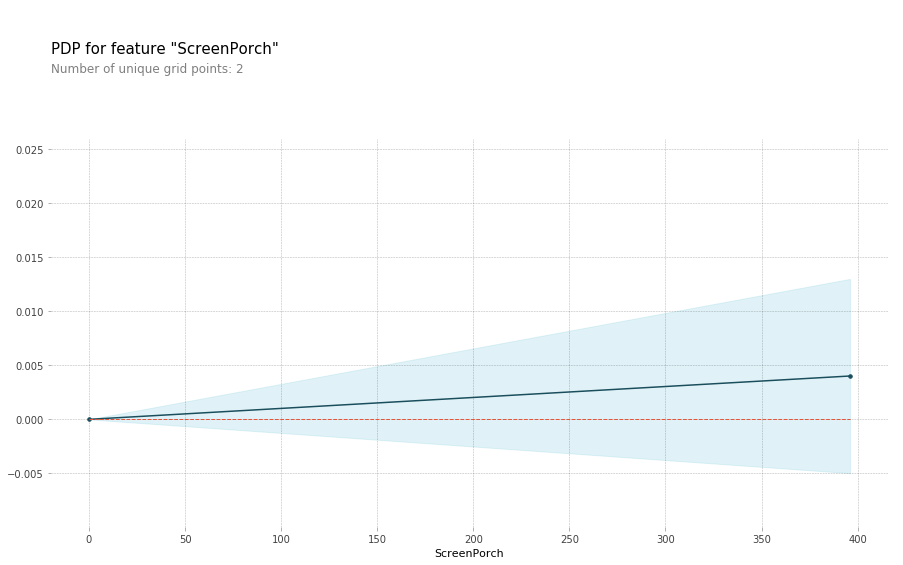

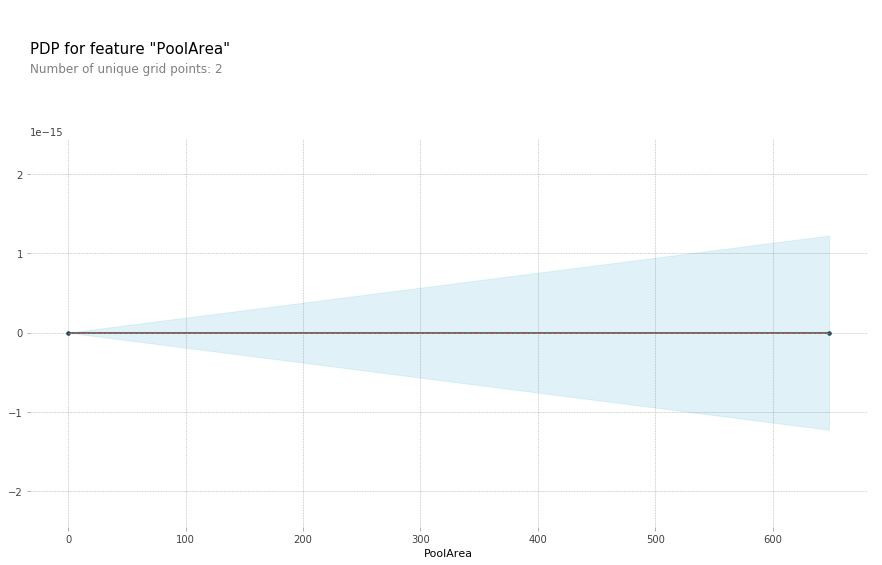

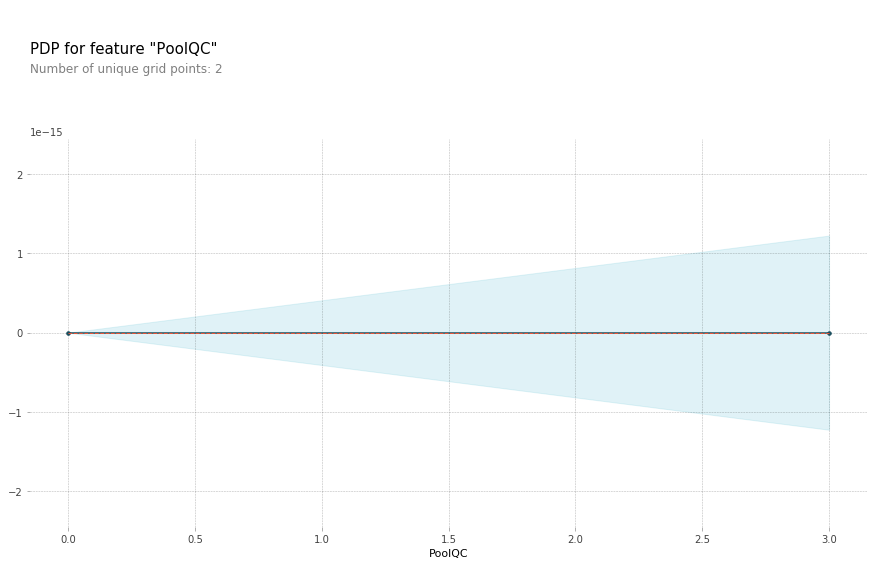

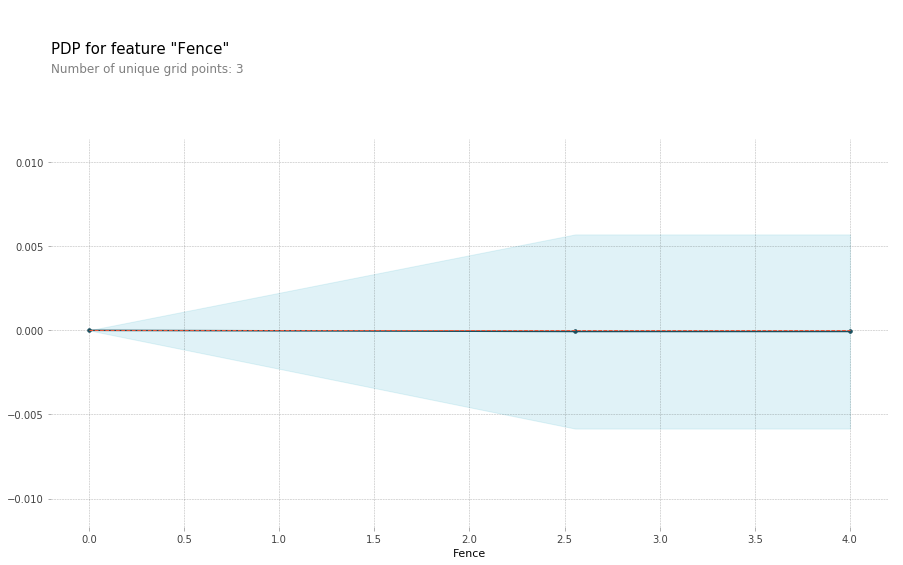

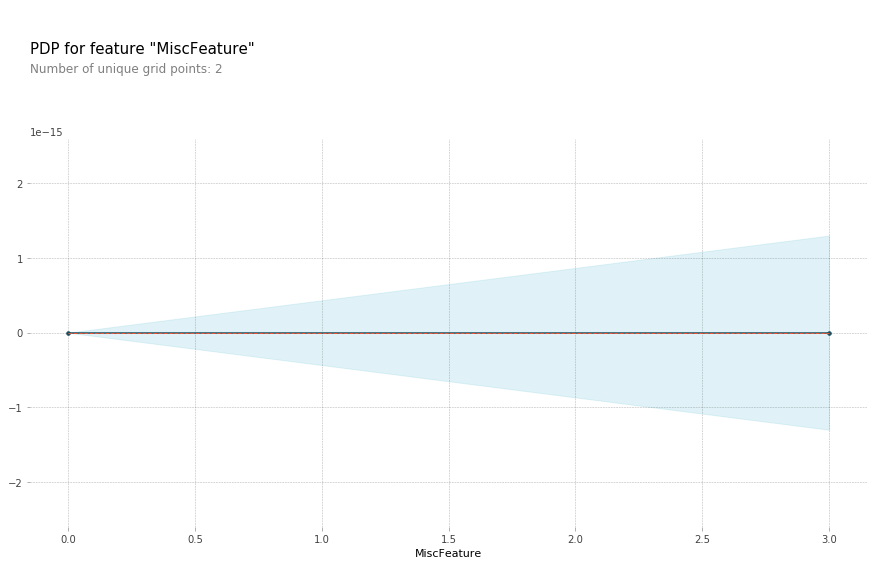

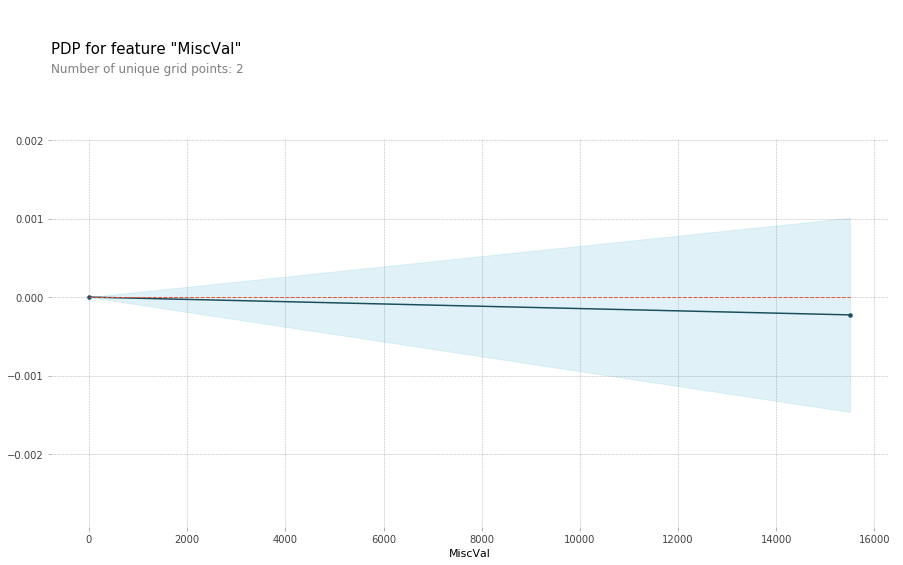

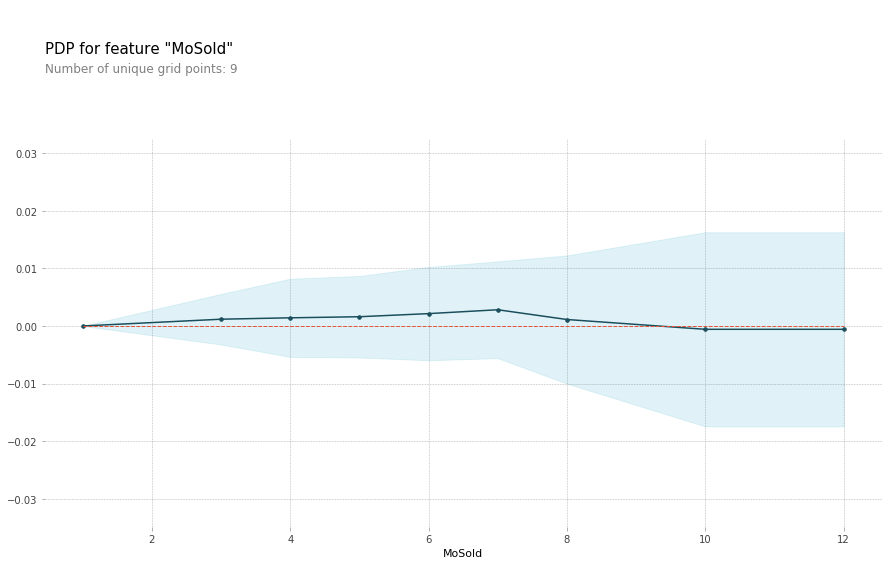

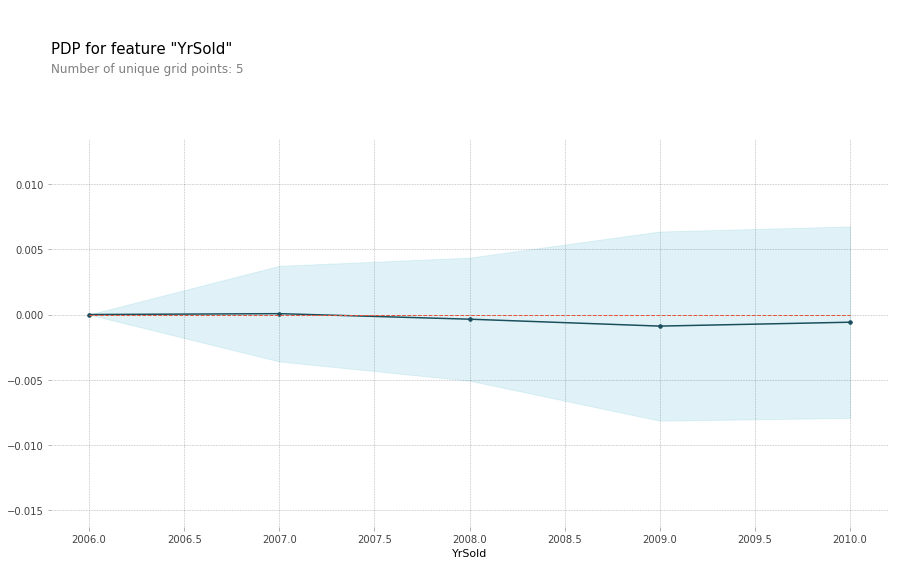

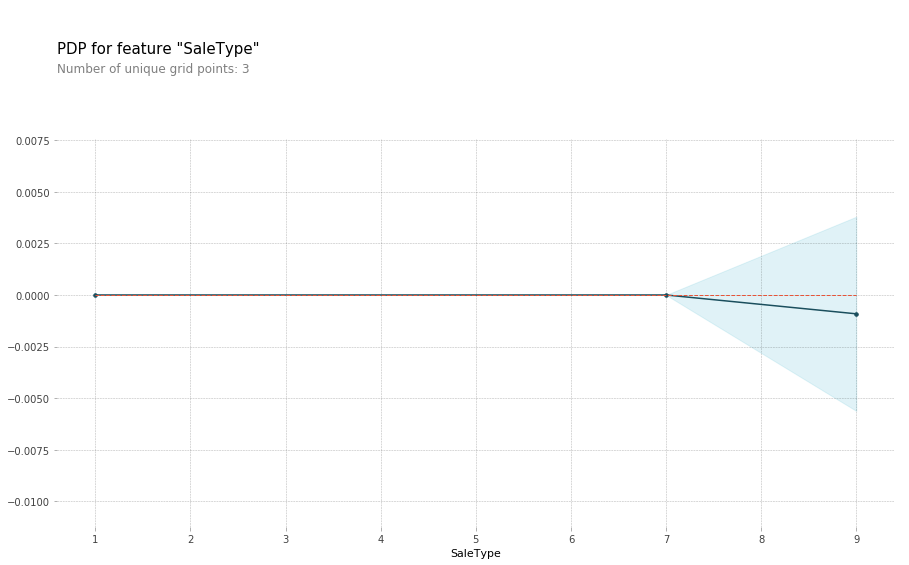

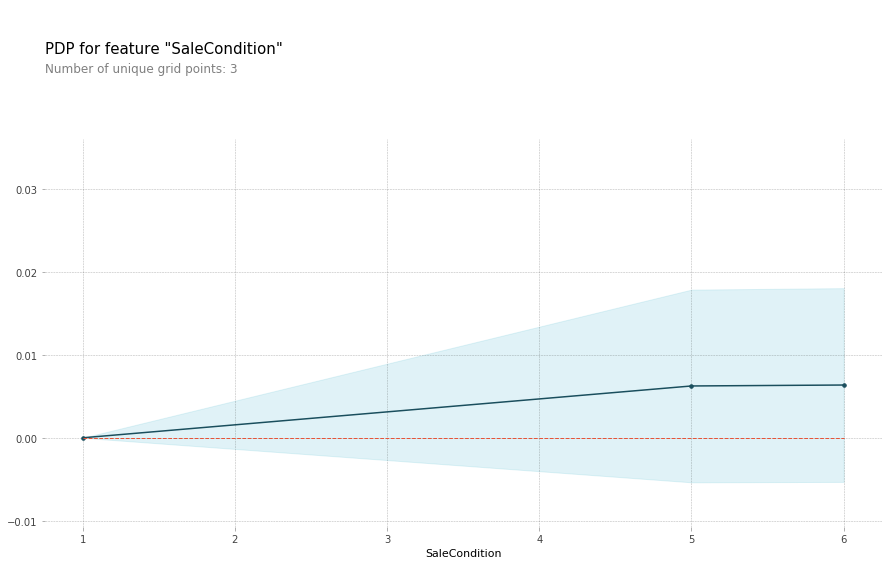

In [15]:
for feat_name in val_X.columns:
#for feat_name in base_features:
    #pdp_dist = pdp.pdp_isolate(model=m, dataset=val_X, model_features=base_features, feature=feat_name)
    pdp_dist = pdp.pdp_isolate(model = m, dataset=val_X, model_features=val_X.columns, feature=feat_name)

    pdp.pdp_plot(pdp_dist, feat_name)

    plt.show()

## SHAP values for selected rows

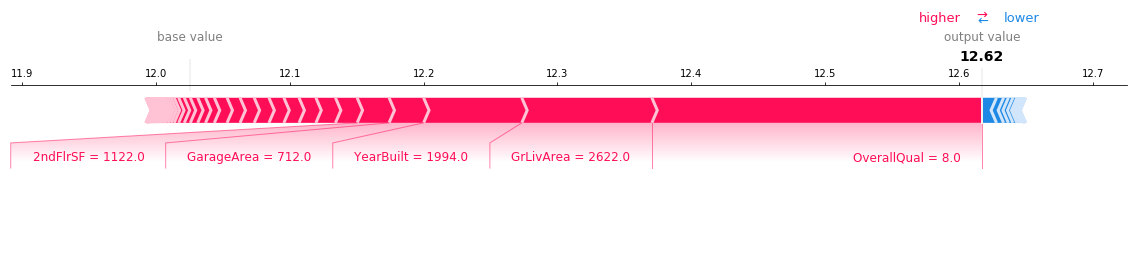

In [16]:
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(val_X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], val_X.iloc[1,:], matplotlib=True) ## change shap and val_X

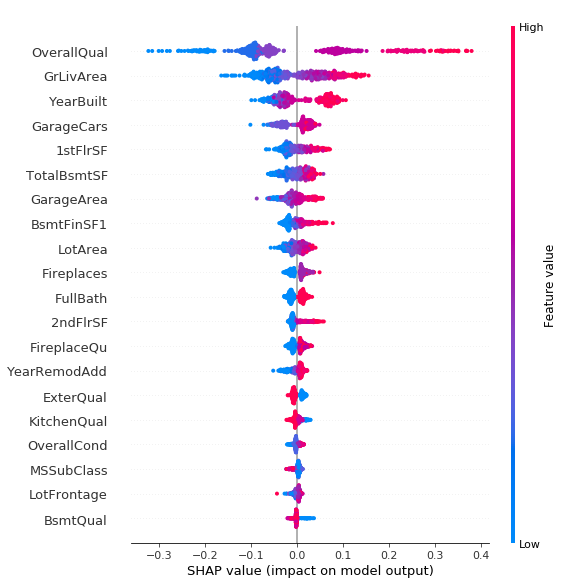

In [17]:
shap.summary_plot(shap_values, val_X)

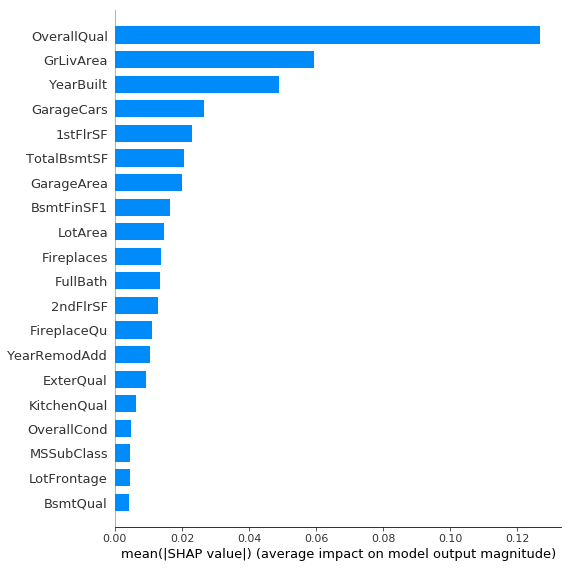

In [18]:
shap.summary_plot(shap_values, val_X, plot_type="bar")

## Submitting Predictions

In [19]:
pred = m.predict(df_test)
submission = pd.read_csv('../input/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [20]:
submission['SalePrice'] = np.exp(pred)   ## Convert log back 
submission.to_csv('rf_submission_v1.csv', index=False)